# OVERVIEW

This project is being done in reverse order: Convolutional Neural Network first followed by the Multilayer Perceptron, which is the order in which they were completed. This was done in order to keep both sections of code as structurally similar to each other as possible so as to make comparisons between the two easier later.

#HARDWARE CONFIGURATION - CUDA SETUP

In [0]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# SECTION 1 - CONVOLUTIONAL NEURAL NETWORK

Code based on https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

## Importing Data

In [0]:
#Algorithm Configuration
BATCH_SIZE = 4

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

#Defining a linear transformation function that accomplishes multiple things (in this case, turning input image data into continuous-valued tensors and normalizing them)
transform = transforms.Compose(
    [transforms.ToTensor(),                                 #Function to take input image data and turn its values into tensors of continuous values [0,1] from integers values [0,255].
     transforms.Normalize( (0.5,0.5,0.5),(0.5,0.5,0.5)) ]   #Function to normalize input tensors to be used. Configured with two arguments: the desired mean within the three channels; and the desired standard deviation within the three channels, hence (m,m,m),(s,s,s) input.
)

#We're going to first literally import the training dataset, and then we're going to create a trainLoader object whose purpose is to more efficiently allow the training dataset to be loaded into code later.
trainset = torchvision.datasets.CIFAR10( root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

#Same thing as above; literally importing the test set followed by wrapping it in a loader for use later.
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

#And for some reason we're going to hardcode the names of classes rather than extracting them. I guess that reduces time to execute code though since it is 60000 images.
classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

Files already downloaded and verified
Files already downloaded and verified


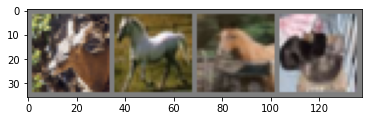

 deer horse horse   cat


In [0]:
#Previewing images
import matplotlib.pyplot as plt
import numpy as np

#This shows the image when called
def imshow(img):
  img = img / 2 + 0.5 #Undoing the previous normalization
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

#Grab some training images to preview
dataiter = iter(trainloader)  #Hey look the loader's being useful
images, labels = dataiter.next()

#Show the images
imshow(torchvision.utils.make_grid(images))
#Print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE)))

my god these images are ugly

Agree！

##Examplary Convolutional Neural Network (Fully Commented)

The following section follows the tutorial linked at the beginning of Section 1 quite closely and makes sense of it. There follows the next section which attempts to wrap all the code below into a single function that would allow for easy tuning of this network's hyperparametres.

### Convolutional Neural Network Configuration

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

  #We define the network in its constructor here.
  def __init__(self):
    super(Net,self).__init__()
    #Interesting to note is that the nn class this is based on automatically takes the following modules we add as attributes as parametres to the neural network.
    self.conv1  = nn.Conv2d(3,6,5)          #Define a convolution layer comprising of 6 filters of shape 5x5x3 applied without padding and of default stride 1.
    self.pool2  = nn.MaxPool2d(2,2)         #Define a max pool layer of kernel size 2 (and thereby filter shape 2x2) a stride 2.
    self.conv3  = nn.Conv2d(6,16,5)         #Define a convolution layer comprising of 16 filters of shape 5x5x6 applied without padding and of default stride 1.
    self.pool4  = nn.MaxPool2d(2,2)         #Define a 2x2 stride 2 max pool layer
    self.fc5    = nn.Linear(16*5*5,120)     #Define a fully connected bipartite network between the previous 16*5*5 amount of nodes and the this layer's 120 nodes.
    self.fc6    = nn.Linear(120,84)         #Define a fully connected bipartite network between the previous layer's 120 nodes and this layer's 84 nodes
    self.fc7    = nn.Linear(84,10)          #Define a fully connected bipartite network between the previous layer's 84 nodes and this layer's 10 nodes (which will later be used as the softmax output layers)

  #Essentially the "classify()" function, though since it's a network we're basically just pushing x through the network forward.
  def forward(self,x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = F.relu(x)
    x = self.pool4(x)
    x = x.view( -1, 16*5*5 )    #Ensures that the output x from the previous pool is in a shape compatible with the next layer's inputs.
    x = self.fc5(x)
    x = F.relu(x)
    x = self.fc6(x)
    x = F.relu(x)
    x = self.fc7(x)
    return x



net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc5): Linear(in_features=400, out_features=120, bias=True)
  (fc6): Linear(in_features=120, out_features=84, bias=True)
  (fc7): Linear(in_features=84, out_features=10, bias=True)
)

### Loss Function Configuration

In [0]:
import torch.optim as optim

#Use Cross Entropy Loss as our loss function
criterion = nn.CrossEntropyLoss()
#Configure a Stochastic Gradient Descent optimizer keeping in mind all the parametres (the layers of our network) we defined in Net.__init__() earlier as well as a learning rate and momentum parametre.
optimizer = optim.SGD( net.parameters(), lr=0.001, momentum=0.9 )

### Training and Testing

####Training the network

In [0]:
NUMBER_OF_EPOCHS = 2

for epoch in range(NUMBER_OF_EPOCHS):

  average_loss_over_epoch = 0.0
  for i, data in enumerate( trainloader, 0 ):
    #Get the subset of inputs and labels provided by trainloader for this iteration
    inputs, labels = data       #Getting the subsets
    inputs = inputs.to(device)  #Converting for CUDA use
    labels = labels.to(device)  #Converting for CUDA use

    #Reset gradients to zero to prevent leaking gradient values between training subsets
    optimizer.zero_grad()

    #Run a gradient descent iteration
    outputs = net(inputs)             #Classify inputs and see what the network currently predicts for each
    loss = criterion(outputs,labels)  #Calculate the loss for each output classification
    loss.backward()                   #Run through the backpropagation and communicate this to the optimizer.
    optimizer.step()                  #With the information from the loss function, step forward in SGD.

    average_loss_over_epoch += loss.item()
    if i%2000 == 1999:
      print('[%d,%5d] loss: %.3f' %( epoch+1 , i+1, average_loss_over_epoch/2000 ) )
      average_loss_over_epoch = 0.0

print('Finished Training')

[1, 2000] loss: 2.192
[1, 4000] loss: 1.810
[1, 6000] loss: 1.655
[1, 8000] loss: 1.562
[1,10000] loss: 1.499
[1,12000] loss: 1.458
[2, 2000] loss: 1.393
[2, 4000] loss: 1.359
[2, 6000] loss: 1.337
[2, 8000] loss: 1.312
[2,10000] loss: 1.290
[2,12000] loss: 1.263
Finished Training


In [0]:
FILE_PATH_FOR_SAVING_NETWORK = './cifar_net.pth'                #By default this path is './cifar_net.pth'      
torch.save( net.state_dict(), FILE_PATH_FOR_SAVING_NETWORK)    #Save the trained model

####Testing the trained network

#####Manual Small-Sample Validation (Part 1 of 2)

Checking that the input images are working as expected

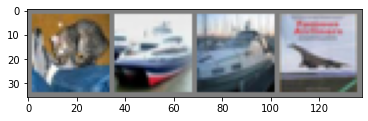

GroundTruth:    cat  ship  ship plane


In [0]:
#We are first going to check that the loader is working as expected by seeing what images it outputs and what target classification label it gives associated to said output.
dataiter = iter(testloader)   #turn it into an iter cause that let you extract with the .next method. Otherwise you'd be dealing with methods that aren't meant to be used by the user directly like this.
images, labels = dataiter.next()  #extract the next set of images and their associated labels for manual checking
imshow(torchvision.utils.make_grid(images)) #show the next set of images
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE))) #show the next set of labels associated to those images in their respective order.

Reloading our previously trained model. The following code block is only necessary if the network you want to train isn't the most recently trained network and is instead saved.

In [0]:
FILE_PATH_FOR_LOADING_NETWORK = './cifar_net.pth'   #By default it is a copy paste of FILE_PATH_FOR_SAVING_NETWORK. Should you actually have done something special, however, you can load a different path.
net = Net()
net.load_state_dict(torch.load(FILE_PATH_FOR_LOADING_NETWORK))

<All keys matched successfully>

##### Manual Small-Sample Validation (Part 2 of 2)

Checking that the trained network is working as expected by reusing the sample from Manual Validation (Part 1 of 2) images and labels and seeing that the loaded model isn't spouting nonsense (ie the accuracy is sufficiently high among the samples tested here that we can assume that something is working in the network).

In [0]:
output = net(images)    #using the trained network above and seeing what output it yields
print(output)

tensor([[-1.0730, -2.3319, -0.2923,  2.7318,  1.5462,  2.0395,  1.9535, -0.5346,
         -1.0999, -2.4997],
        [ 4.9053,  5.8790, -1.8647, -3.6054, -2.8259, -4.5598, -5.1514, -3.6202,
          6.6266,  4.3755],
        [ 2.0834,  2.1431, -0.6332, -1.4171, -0.9529, -2.1058, -2.4664, -1.3270,
          3.0427,  1.2655],
        [ 5.9687,  0.9684,  1.5757, -2.7218,  1.3235, -3.9440, -2.6680, -2.8336,
          3.8451,  0.5588]], grad_fn=<AddmmBackward>)


Note that the output provided by net( input_features ) is not actually a classification, but rather the output set of activations that a softmax function would normally use; with 10 possible classifications, for n amount of instances inputted it will return a nx10 array (Seems to actually use the tensor datatype, mind you)
To actually turn this into the human classifications, we use:

tensor([4.2838, 6.3262, 3.2699, 4.0211], device='cuda:0',
       grad_fn=<MaxBackward0>)
tensor([1, 8, 4, 6], device='cuda:0')


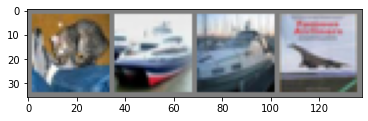

GroundTruth:    cat  ship  ship plane
Predicted:  car ship deer frog


In [0]:
#To actually turn this into the human classifications, we use:
output = net(images)    #using the trained network above and seeing what output it yields
activation_of_predicted, predicted_classification_indices = torch.max(outputs,1)  #Apply a softmax function
print(activation_of_predicted)                                                    #First output is the actual value that was the maximum - ie the associated activation for each output class
print(predicted_classification_indices)                                           #The output class - albeit in index form
predicted_classification_indices_as_classes = ""                                  #We turn these index-form classifications into word-form classifications
for j in range(BATCH_SIZE):
  predicted_classification_indices_as_classes = predicted_classification_indices_as_classes + " " + classes[predicted_classification_indices[j]] #Building a string of those classifications for printing
#Now we show again the images and their actual classifications before now showing what our network predicts for those.
imshow(torchvision.utils.make_grid(images)) #show the next set of images
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE))) #show the next set of labels associated to those images in their respective order.
print('Predicted: ' + predicted_classification_indices_as_classes)                #Here's what it actually looks like

Okay so if I am to be completely honest, the expected outputs of {cat ship ship plane} versus the predicted outputs of {plane bird bird dog} give me some serious doubts to the functaionality of the algorithm. However, considering the fact that this dataset comprises of 10 classifications each of which take up the same-sized division of the entire dataset, if our algorithm were to be predicting randomly, then using a binomial pmf function we find that the likeliyhood of obtaining 1/4 accuracy is (4 choose 1)(0.1)^1*(0.9)^3 = ~30%. Which means that what we have is technically unlikely.

Mind you 30% isn't that unlikely so I still don't know if we've got something working. We'll only really know by actually going ahead and using the entire test dataset and seeing how accurate it is there; so to use the entire dataset we proceed by using the entire testing dataset in the following loop:

####Full Test Dataset Testing

In [0]:
#General statistic tracking
correct = 0 #Tracking total amount of correct classifications
total = 0   #tracking total amount of classifications
#Class-By-Class statistic tracking
class_correct = list(0. for i in range(10)) #Tracking amount of correct classifications per class
class_total = list(0. for i in range(10))   #Tracking amount of classifications per class
with torch.no_grad():     #We tell the pytorch that we will not need to compute any gradients, so it can save on physical resources.
  for data in testloader:   #We're going to let the testloader give us the 10000 test data in batches it believes appropriate
    images, labels = data   #extract images and labels
    images = images.to(device)
    labels = labels.to(device)
    outputs = net(images)   #classify
    predicted = torch.max(outputs,1).indices  #Apply a softmax on the output classification activation array. torch.max() gives an object of the max values and the indices they were found at. 
                                              #The indices is the classification index, which is what we need.
    total += labels.size(0) #Figure out how many predictions were just conducted and add them in
    correct += (predicted == labels).sum().item() #Figure out how many correct predictions were made and add them in.
    classification_correctnesses = (predicted == labels)   #Get the array of booleans for whether or not each classification is accurate
    for i in range(BATCH_SIZE):  #For each set of the BATCH_SIZE features, real classification, and predicted classification tuple we tally up the scores
      label = labels[i]   #Figure out what classification was attempted for each tuple
      class_correct[label] += classification_correctnesses[i].item()  #If the particular classification label is right, increment correct classifications of this class by one.
                                                                      #item() merely extracts the valued contained by the tensor instance.
      class_total[label] += 1 #Indicate that a classification has been attempted for this label

#General Statistic output
print('Overall accuracy of the network on the 10000 test images: %d %%' % (100*correct/total) )
#Class-By-Class Statistic output
for i in range(10):
  print('Accuracy of %5s : %2d %%' % (
      classes[i], 100*class_correct[i]/class_total[i]
  ))

Overall accuracy of the network on the 10000 test images: 55 %
Accuracy of plane : 57 %
Accuracy of   car : 63 %
Accuracy of  bird : 31 %
Accuracy of   cat : 35 %
Accuracy of  deer : 32 %
Accuracy of   dog : 52 %
Accuracy of  frog : 83 %
Accuracy of horse : 62 %
Accuracy of  ship : 71 %
Accuracy of truck : 68 %


##EXPERIMENTING WITH DIFFERENT CONVOLUTIONAL NEURAL NETWORKS

Here we experiment with hyperparametres - that is, the configuration of the neural network. To do this, we first create a function that trains and tests a neural network configuration passed in (like how we defined the class Net earlier for use in our neural network) and checks out how accurate it is.

###Analysis Function

An encapsulation of the entire training and testing process around a CNN configuration.

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
import numpy as np
import time

def trainAndTestConvolutionNetworkProvided(NetworkClass,maxNumberOfEpochs=200,batch_size=2000,number_of_workers=0,verbose=False,name="unnamed neural network",silent=False,learning_rate=0.05, momentum=0.75, criterion=nn.CrossEntropyLoss(), use_gpu=True):
  #=============================================================================
  #
  # SET UP
  #
  #=============================================================================
  print( ("Running training and testing function on " + str(name)).upper() )
  #--- Variables to do with keeping track of interesting metrics ---#
  statistics = dict()
  statistics["per_batch"] = dict()
  statistics["per_epoch"] = dict()
  statistics["per_epoch"]["training"] = dict()
  statistics["per_epoch"]["testing"] = dict()
  statistics["per_batch"]["batch"] = list()
  statistics["per_batch"]["cost"] = list()
  statistics["per_epoch"]["epoch"] = list()
  statistics["per_epoch"]["training"]["loss"] = list()
  statistics["per_epoch"]["training"]["accuracy"] = list()
  statistics["per_epoch"]["testing"]["loss"] = list()
  statistics["per_epoch"]["testing"]["accuracy"] = list()
  #--- DATA SET SETUP ---#
  #DataLoaders mainly used and as suggested in the tutorial
  preprocessing_transforms = transforms.Compose(
      [ transforms.ToTensor(),  
       transforms.Normalize( (0.5,0.5,0.5),(0.5,0.5,0.5) ) ]    )
  training_dataset_download = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=preprocessing_transforms)
  training_dataset_loader = torch.utils.data.DataLoader(training_dataset_download, batch_size=batch_size, shuffle=True, num_workers=number_of_workers)
  testing_dataset_download = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocessing_transforms)
  testing_dataset_loader = torch.utils.data.DataLoader(testing_dataset_download, batch_size=batch_size, shuffle=False, num_workers=number_of_workers)
  dataset_classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')
  #--- CONVOLUTIONAL NEURAL NETWORK SETUP ---#
  network = NetworkClass()
  #--- OPTIMIZER AND LOSS CRITERION SETUP ---#
  network_optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
  optimizer_criterion = criterion
  #--- HARWARE ACCELERATION ---#
  device = torch.device("cuda:0" if torch.cuda.is_available() and use_gpu else "cpu")
  network.to(device)
  if(verbose and not silent and use_gpu ): print("Found device "+ str(device) )
  #--- SANITY CHECKING ---#
  if(verbose and not silent):
    small_sample_images, small_sample_labels = iter(testing_dataset_loader).next()
    small_sample_images = small_sample_images.to(device)
    small_sample_labels = small_sample_labels.to(device)
    print('GroundTruth: ', ' '.join( '%5s' % dataset_classes[small_sample_labels[j]] for j in range(batch_size) ) )
    small_sample_predictions = torch.max( network(small_sample_images) , 1 ).indices
    print('Predicted: ' , ' ' .join( '%5s' % dataset_classes[small_sample_predictions[j]] for j in range(batch_size) ) )



  #=============================================================================
  #
  # HELPER FUNCTIONS
  #
  #=============================================================================
  #Evaluate the accuracy of the network as it currently stands using the data wrapped by the dataloader.
  def evaluate_network_acc(dataloader):   
    correct_for_class = list(0. for i in range(10))
    total_for_class = list(0. for i in range(10))
    correct_overall = 0
    total_overall = 0
    with torch.no_grad():
      for data_batch in dataloader:
        image_batch, label_batch = data_batch
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)
        batch_activations = network(image_batch)
        batch_predictions = torch.max(batch_activations,1).indices
        batch_accuracies = (batch_predictions == label_batch).squeeze()
        for i in range(batch_size):
          expected_batch_element_label = label_batch[i]
          correct_for_class[expected_batch_element_label] += batch_accuracies[i].item()
          correct_overall += batch_accuracies[i].item()
          total_for_class[expected_batch_element_label] += 1
          total_overall += 1
    return correct_for_class, total_for_class, correct_overall, total_overall
  #Extracts all images and labels
  def extract_entire_dataset(dataloader): 
    images = None
    labels = None
    for i, data_batch in enumerate(dataloader):
      #Parse for CUDA use
      inputs_batch, labels_batch = data_batch
      inputs_batch = inputs_batch.to(device)
      labels_batch = labels_batch.to(device)
      if images == None:
        images = inputs_batch
        labels = labels_batch
      else:
        images = torch.cat( (images,inputs_batch), 0 )
        labels = torch.cat( (labels,labels_batch), 0 )
    return images, labels
  #Get the network's accuracy and loss on provided dataset
  def evaluate_acc_and_loss(images,labels):  
    total_correct = 0
    total_overall = 0
    loss = -1
    with torch.no_grad():
      activations = network(images)
      predictions = torch.max(activations,1).indices
      predictions = (predictions == labels).squeeze()
      #Accuracy-related
      for i in range( len(images) ):
        total_correct += predictions[i].item()
      total_overall = len(images)
      #Loss related
      loss = optimizer_criterion(activations,labels)
      loss = loss.item()
    return total_correct/total_overall, loss



  #=============================================================================
  #
  # TRAINING
  #
  #=============================================================================
  #Full extracted datasets useful for evaluating accuracy in one shot
  extraction_start_time = time.time()
  training_images, training_labels = extract_entire_dataset(training_dataset_loader)
  testing_images, testing_labels = extract_entire_dataset(testing_dataset_loader)
  extraction_end_time = time.time()
  #--- TRAINING ---#
  if(verbose and not silent): print("Begun Training")
  epoch_times = list()
  training_time = time.time()
  under_cost_threshold = False
  #Cover over the training dataset epoch-number of times
  for epoch in range( maxNumberOfEpochs ):
    running_loss = 0.0
    epoch_start_time = time.time()
    #Go through all batches of the training dataset
    for i, data_batch in enumerate(training_dataset_loader, 0):
      #Parse for CUDA use
      inputs_batch, labels_batch = data_batch
      inputs_batch = inputs_batch.to(device)
      labels_batch = labels_batch.to(device)
      #Predict, Calculate Loss, and Optimize
      network_optimizer.zero_grad()
      batch_predictions = network(inputs_batch)
      batch_loss = optimizer_criterion(batch_predictions,labels_batch)
      batch_loss.backward()
      network_optimizer.step()
      running_loss += batch_loss.item()
      #Reporting every 2000 iterations
      if i%2000 == 1999 and not silent:
        print('[%d,%5d] loss: %.3f' % (epoch+1, i+1, running_loss/2000) )
        running_loss = 0.0
      #Graphing cost over iterations
      statistics["per_batch"]["batch"].append(i+epoch*50000/batch_size)
      statistics["per_batch"]["cost"].append(batch_loss.item())
    #Measure the accuracy and loss of the network at this epoch
    statistics["per_epoch"]["epoch"].append(epoch)
    trainset_acc, trainset_loss = evaluate_acc_and_loss(training_images,training_labels)
    testset_acc, testset_loss = evaluate_acc_and_loss(testing_images,testing_labels)
    statistics["per_epoch"]["training"]["accuracy"].append( trainset_acc)
    statistics["per_epoch"]["training"]["loss"].append(     trainset_loss)
    statistics["per_epoch"]["testing"]["accuracy"].append(  testset_acc)
    statistics["per_epoch"]["testing"]["loss"].append(      testset_loss)
    #Announce the end of an epoch
    if not silent:
      print("[%d epoch complete]" %(epoch+1))
    epoch_times.append(time.time() - epoch_start_time)
  #Track Time
  training_time = time.time() - training_time
  if(verbose and not silent):  print("Fininshed Training.")
  if not silent:
    print("Training Time: " + str(training_time))
    print("Average time per epoch: " + str(training_time/maxNumberOfEpochs))
  #--- MEASURING TRAINING ACCURACY (NOT K-FOLDED) ---#
  if(verbose and not silent): print("Begun Training Accuracy Measuring")
  correct_for_class, total_for_class, correct_overall, total_overall = evaluate_network_acc(training_dataset_loader)
  if not silent:
    for i in range(10):
      print('Training Accuracy of %5s : %2d %%' % (dataset_classes[i], 100*correct_for_class[i] / total_for_class[i]) )
      total_correct = correct_for_class[i]
      total_attempts = total_for_class[i]
    print('Training Accuracy overall: %2d %%' % ( 100*correct_overall/total_overall ) )


  #=============================================================================
  #
  # TESTING
  #
  #=============================================================================
  #--- TESTING ---#
  if(verbose and not silent): print("Begun Testing")
  correct_for_class, total_for_class, correct_overall, total_overall = evaluate_network_acc(testing_dataset_loader)
  if not silent:
    for i in range(10):
      print('Accuracy of %5s : %2d %%' % (dataset_classes[i], 100*correct_for_class[i] / total_for_class[i]) )
      total_correct = correct_for_class[i]
      total_attempts = total_for_class[i]
    print('Accuracy overall: %2d %%' % ( 100*correct_overall/total_overall ) )
  


  #=============================================================================
  #
  # RETURN-DATA PARSING
  #
  #=============================================================================
  #--- PARSING RETURN VALUE RESULTS ---#
  results = dict()
  results["name"] = name
  results["overall_accuracy"] = correct_overall/total_overall
  results["class_accuracies"] = dict()
  for i in range(10):
    results["class_accuracies"][dataset_classes[i]] = correct_for_class[i] / total_for_class[i]
  results["statistics"] = statistics
  results["training_time"] = training_time
  results["epoch_times"] = epoch_times
  results["extraction_time"] = extraction_end_time - extraction_start_time
  return results

###The Network Configurations

Here we write all the networks configurations to be trained and tested on the dataset.

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class TutorialCNN(nn.Module):

  #We define the network in its constructor here.
  def __init__(self):
    super(TutorialCNN,self).__init__()
    #Interesting to note is that the nn class this is based on automatically takes the following modules we add as attributes as parametres to the neural network.
    self.conv1  = nn.Conv2d(3,6,5)          #Define a convolution layer comprising of 6 filters of shape 5x5x3 applied without padding and of default stride 1.
    self.pool2  = nn.MaxPool2d(2,2)         #Define a max pool layer of kernel size 2 (and thereby filter shape 2x2) a stride 2.
    self.conv3  = nn.Conv2d(6,16,5)         #Define a convolution layer comprising of 16 filters of shape 5x5x6 applied without padding and of default stride 1.
    self.pool4  = nn.MaxPool2d(2,2)         #Define a 2x2 stride 2 max pool layer
    self.fc5    = nn.Linear(16*5*5,120)     #Define a fully connected bipartite network between the previous 16*5*5 amount of nodes and the this layer's 120 nodes.
    self.fc6    = nn.Linear(120,84)         #Define a fully connected bipartite network between the previous layer's 120 nodes and this layer's 84 nodes
    self.fc7    = nn.Linear(84,10)          #Define a fully connected bipartite network between the previous layer's 84 nodes and this layer's 10 nodes (which will later be used as the softmax output layers)
    #Number of parametres comprises of:
    # (5*5*3+1)*6     = 456 parametres in conv1
    # (5*5*6+1)*16    = 2416 parametres in conv3
    # (16*5*5+1)*120  = 48120 parametres in fc5
    # (120+1)*84      = 10164 parametres in fc6
    # (84+1)*10       = 850 parametres in fc7
    # In total, there are 62,006 parametres tuned during training in this net.

  #Essentially the "classify()" function, though since it's a network we're basically just pushing x through the network forward.
  def forward(self,x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = F.relu(x)
    x = self.pool4(x)
    x = x.view( -1, 16*5*5 )
    x = self.fc5(x)
    x = F.relu(x)
    x = self.fc6(x)
    x = F.relu(x)
    x = self.fc7(x)
    return x

class SmallerCNN(nn.Module):

  #We define the network in its constructor here.
  def __init__(self):
    super(SmallerCNN,self).__init__()
    #Interesting to note is that the nn class this is based on automatically takes the following modules we add as attributes as parametres to the neural network.
    #Data is in form 32x32x3
    self.conv1  = nn.Conv2d(3,8,5)          #Define a convolution layer comprising of 8 filters of shape 5x5x3 applied without padding and of default stride 1.
    #Activations in form 28x28x8
    self.pool2  = nn.MaxPool2d(2,2)         #Define a max pool layer of kernel size 2 (and thereby filter shape 2x2) a stride 2.
    #Activations in form 14x14x8
    self.conv3  = nn.Conv2d(8,12,5)         #Define a convolution layer comprising of 12 filters of shape 5x5x8 applied without padding and of default stride 1.
    #Activations in form 10x10x12
    self.pool4  = nn.MaxPool2d(2,2)         #Define a 2x2 stride 2 max pool layer
    #Activations in form 5x5x12
    self.fc5    = nn.Linear(12*5*5,100)     #Define a fully connected bipartite network between the previous 12*5*5 amount of nodes and the this layer's 100 nodes.
    #Activations in form 100
    self.fc6    = nn.Linear(100,40)         #Define a fully connected bipartite network between the previous layer's 100 nodes and this layer's 40 nodes
    self.fc7    = nn.Linear(40,10)          #Define a fully connected bipartite network between the previous layer's 40 nodes and this layer's 10 nodes (which will later be used as the softmax output layers)
    #Number of parametres comprises of:
    # (5*5*3+1)*8     = 608 parametres in conv1
    # (5*5*8+1)*12    = 2412 parametres in conv3
    # (12*5*5+1)*100  = 30100 parametres in fc5
    # (100+1)*40      = 4040 parametres in fc6
    # (40+1)*10       = 410 parametres in fc7
    # In total, there are 37,570 parametres tuned during training in this net.
    # That is about 61% of the tutorial's parametres.

  #Essentially the "classify()" function, though since it's a network we're basically just pushing x through the network forward.
  def forward(self,x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = F.relu(x)
    x = self.pool4(x)
    x = x.view( -1, 12*5*5 )
    x = self.fc5(x)
    x = F.relu(x)
    x = self.fc6(x)
    x = F.relu(x)
    x = self.fc7(x)
    return x

class TinyCNN(nn.Module):

  #We define the network in its constructor here.
  def __init__(self):
    super(TinyCNN,self).__init__()
    #Interesting to note is that the nn class this is based on automatically takes the following modules we add as attributes as parametres to the neural network.
    #Data is in form 32x32x3
    self.conv1  = nn.Conv2d(3,8,5)          #Define a convolution layer comprising of 8 filters of shape 5x5x3 applied without padding and of default stride 1.
    #Activations in form 28x28x8
    self.pool2  = nn.MaxPool2d(2,2)         #Define a max pool layer of kernel size 2 (and thereby filter shape 2x2) a stride 2.
    #Activations in form 14x14x8
    self.conv3  = nn.Conv2d(8,12,5)         #Define a convolution layer comprising of 12 filters of shape 5x5x8 applied without padding and of default stride 1.
    #Activations in form 10x10x12
    self.pool4  = nn.MaxPool2d(2,2)         #Define a 2x2 stride 2 max pool layer
    #Activations in form 5x5x12
    self.fc5    = nn.Linear(12*5*5,25)     #Define a fully connected bipartite network between the previous 12*5*5 amount of nodes and the this layer's 100 nodes.
    self.fc6    = nn.Linear(25,40)         #Define a fully connected bipartite network between the previous layer's 100 nodes and this layer's 40 nodes
    self.fc7    = nn.Linear(40,10)          #Define a fully connected bipartite network between the previous layer's 40 nodes and this layer's 10 nodes (which will later be used as the softmax output layers)
    #Number of parametres comprises of:
    # (5*5*3+1)*8     = 608 parametres in conv1
    # (5*5*8+1)*12    = 2412 parametres in conv3
    # (12*5*5+1)*25   = 7525 parametres in fc5
    # (25+1)*40       = 1040 parametres in fc6
    # (40+1)*10       = 410 parametres in fc7
    # In total, there are 11,995 parametres tuned during training in this net.
    # That is about 19% of the tutorial's parametres.

  #Essentially the "classify()" function, though since it's a network we're basically just pushing x through the network forward.
  def forward(self,x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = F.relu(x)
    x = self.pool4(x)
    x = x.view( -1, 12*5*5 )
    x = self.fc5(x)
    x = F.relu(x)
    x = self.fc6(x)
    x = F.relu(x)
    x = self.fc7(x)
    return x

class TinierCNN(nn.Module):

  #We define the network in its constructor here.
  def __init__(self):
    super(TinierCNN,self).__init__()
    #Interesting to note is that the nn class this is based on automatically takes the following modules we add as attributes as parametres to the neural network.
    #Data is in form 32x32x3
    self.conv1  = nn.Conv2d(3,12,5)         #3 input layers, 12 filters of width 5
    #Activations in form 28x28x12
    self.pool2  = nn.MaxPool2d(4,4)         #maxpool
    #Activations in form 7x7x12
    self.conv3  = nn.Conv2d(12,6,5)         #12 input layers, 6 filters of width 5
    #Activations in form 3x3x6
    self.fc4    = nn.Linear(3*3*6,30)       #Fully connect 3*3*6 volume to 30 nodes
    self.fc5    = nn.Linear(30,20)          #Fully connect 30 nodes to 20 nodes
    self.fc6    = nn.Linear(20,10)          #Fully connect the 20 nodes to the final output 10 nodes
    #Number of parametres comprises of:
    # (5*5*3+1)*12    = 912 parametres in conv1
    # (5*5*12+1)*6    = 1806 parametres in conv3
    # (3*3*6+1)*30    = 1650 parametres in fc4
    # (30+1)*20       = 620 parametres in fc5
    # (20+1)*10       = 210 parametres in fc6
    # In total, there are 5198 parametres tuned during training in this net.
    # That is about 43% of the TinyCNN's parametres and 8% of the tutorial's parametres.

  #Essentially the "classify()" function, though since it's a network we're basically just pushing x through the network forward.
  def forward(self,x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = F.relu(x)
    x = x.view( -1, 3*3*6 )
    x = self.fc4(x)
    x = F.relu(x)
    x = self.fc5(x)
    x = F.relu(x)
    x = self.fc6(x)
    return x

#NOT USED: GTX 1070 did not have enough memory to run this model in addition to what was already in memory. This more complex CNN was considered at some point, though.
class BigCNN(nn.Module):

  #We define the network in its constructor here.
  def __init__(self):
    super(BigCNN,self).__init__()
    #Interesting to note is that the nn class this is based on automatically takes the following modules we add as attributes as parametres to the neural network.
    #Data is in form 32x32x3
    self.conv1  = nn.Conv2d(3,20,5)         #3 input layers, 20 filters of width 5
    #Activations in form 28x28x20
    self.pool2  = nn.MaxPool2d(2,2)         #2x2 maxpool
    #Activations in form 14x14x20
    self.conv3  = nn.Conv2d(20,40,5)        #20 input layers, 40 filters of width 5
    #Activations in form 10x10x40
    self.pool4  = nn.MaxPool2d(2,2)         #Define a 2x2 stride 2 max pool layer
    #Activations in form 5x5x40
    self.fc5    = nn.Linear(5*5*40,200)     #Fully connected 40*5*5 nodes to 500 nodes.
    self.fc6    = nn.Linear(200,100)        #Fully connected 500 nodes to 100 nodes
    self.fc7    = nn.Linear(100,40)         #Fully connected 100 nodes to 40 nodes.
    self.fc8    = nn.Linear(40,10)          #Converge 40 nodes to output 10 nodes.
    #Number of parametres comprises of:
    # (5*5*3+1)*20      = 1520 parametres in conv1
    # (5*5*8+1)*40      = 8040 parametres in conv3
    # (40*5*5+1)*200    = 200200 parametres in fc5
    # (200+1)*100       = 20100 parametres in fc6
    # (100+1)*40        = 4040 parametres in fc7
    # (40+1)*10         = 410 parametres in fc8
    # In total, there are 234,310 parametres tuned during training in this net.
    # That is about 378% of the tutorial's parametres.

  #Essentially the "classify()" function, though since it's a network we're basically just pushing x through the network forward.
  def forward(self,x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = F.relu(x)
    x = self.pool4(x)
    x = x.view( -1, 40*5*5 )
    x = self.fc5(x)
    x = F.relu(x)
    x = self.fc6(x)
    x = F.relu(x)
    x = self.fc7(x)
    x = F.relu(x)
    x = self.fc8(x)
    return x

###Testing The Network Configs

So actually the first thing I want to experiment with is adjusting hyperparametres. I want to see what needs to be done to get this the example working as well as it can in the first place. For that, we're going to need a graph of cost over time to get a general idea of how well the algorithm is doing. This grapher will take the dictionary outputted by our trainAndTestConvolutionNetworkProvided() method defined above and graph the statistics.

####graphStatistics()

In [0]:
import matplotlib.pyplot as plt
from scipy.stats import kde

def graphStatistics(Results):
  costsOverBatchesFigure = plt.figure()
  costsOverBatchesFigure.set_figheight(9)
  costsOverBatchesFigure.set_figwidth(15)
  costsOverBatchesPlot = costsOverBatchesFigure.add_subplot(1,1,1)
  costsOverBatchesPlot.scatter( Results["statistics"]["per_batch"]["batch"], Results["statistics"]["per_batch"]["cost"], label="Cost Over Batches" )
  costsOverBatchesPlot.set_xlabel("Batch Number")
  costsOverBatchesPlot.set_ylabel("Batch Cost")
  costsOverBatchesPlot.grid()
  costsOverBatchesFigure.show()

  histCostsOverBatchesFigure = plt.figure()
  histCostsOverBatchesFigure.set_figheight(9)
  histCostsOverBatchesFigure.set_figwidth(15)
  histCostsOverBatchesPlot = histCostsOverBatchesFigure.add_subplot(1,1,1)
  histCostsOverBatchesPlot.hist2d( Results["statistics"]["per_batch"]["batch"], Results["statistics"]["per_batch"]["cost"], bins=40)
  histCostsOverBatchesPlot.set_xlabel("Batch Number")
  histCostsOverBatchesPlot.set_ylabel("Batch Cost")
  histCostsOverBatchesPlot.grid()
  histCostsOverBatchesFigure.show()

  costOverEpochsFigure = plt.figure()
  costOverEpochsFigure.set_figheight(9)
  costOverEpochsFigure.set_figwidth(15)
  costOverEpochsPlot = costOverEpochsFigure.add_subplot(1,1,1)
  costOverEpochsPlot.plot( Results["statistics"]["per_epoch"]["epoch"], Results["statistics"]["per_epoch"]["training"]["loss"], label="Training Cost Over Epochs", color='b' )
  costOverEpochsPlot.plot( Results["statistics"]["per_epoch"]["epoch"], Results["statistics"]["per_epoch"]["testing"]["loss"], label="Testing Cost Over Epochs", color='r' )
  costOverEpochsPlot.set_xlabel("Epoch Number")
  costOverEpochsPlot.set_ylabel("Epoch Training Cost")
  costOverEpochsPlot.legend()
  costOverEpochsPlot.grid()
  costOverEpochsFigure.show()

  accuracyOverEpochsFigure = plt.figure()
  accuracyOverEpochsFigure.set_figheight(9)
  accuracyOverEpochsFigure.set_figwidth(15)
  accuracyOverEpochsPlot = accuracyOverEpochsFigure.add_subplot(1,1,1)
  accuracyOverEpochsPlot.plot( Results["statistics"]["per_epoch"]["epoch"], Results["statistics"]["per_epoch"]["training"]["accuracy"], label="Training Accuracy Over Epochs", color='b' )
  accuracyOverEpochsPlot.plot( Results["statistics"]["per_epoch"]["epoch"], Results["statistics"]["per_epoch"]["testing"]["accuracy"], label="Testing Accuracy Over Epochs", color='r' )
  accuracyOverEpochsPlot.set_xlabel("Epoch Number")
  accuracyOverEpochsPlot.set_ylabel("Epoch Training Accuracy")
  accuracyOverEpochsPlot.legend()
  accuracyOverEpochsPlot.grid()
  accuracyOverEpochsFigure.show()

####Tutorial CNN Training Parametre Tutorial Setup

Running the tutorial CNN exactly as described in the tutorial.

RUNNING TRAINING AND TESTING FUNCTION ON TUTORIAL CONVOLUTIONAL NEURAL NETWORK WITH TUTORIAL TRAINING PARAMETRES
Files already downloaded and verified
Files already downloaded and verified
[1, 2000] loss: 2.168
[1, 4000] loss: 1.902
[1, 6000] loss: 1.671
[1, 8000] loss: 1.611
[1,10000] loss: 1.531
[1,12000] loss: 1.472
[1 epoch complete]
[2, 2000] loss: 1.395
[2, 4000] loss: 1.362
[2, 6000] loss: 1.337
[2, 8000] loss: 1.315
[2,10000] loss: 1.306
[2,12000] loss: 1.263
[2 epoch complete]
Training Time: 103.3113853931427
Average time per epoch: 51.65569269657135
Training Accuracy of plane : 58 %
Training Accuracy of   car : 81 %
Training Accuracy of  bird : 38 %
Training Accuracy of   cat : 20 %
Training Accuracy of  deer : 32 %
Training Accuracy of   dog : 50 %
Training Accuracy of  frog : 84 %
Training Accuracy of horse : 75 %
Training Accuracy of  ship : 69 %
Training Accuracy of truck : 61 %
Training Accuracy overall: 57 %
Accuracy of plane : 59 %
Accuracy of   car : 78 %
Accuracy of 

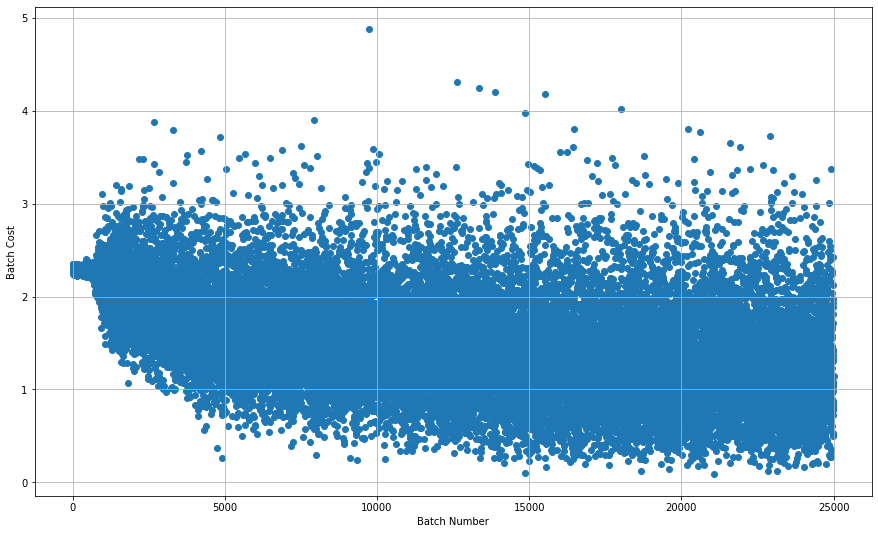

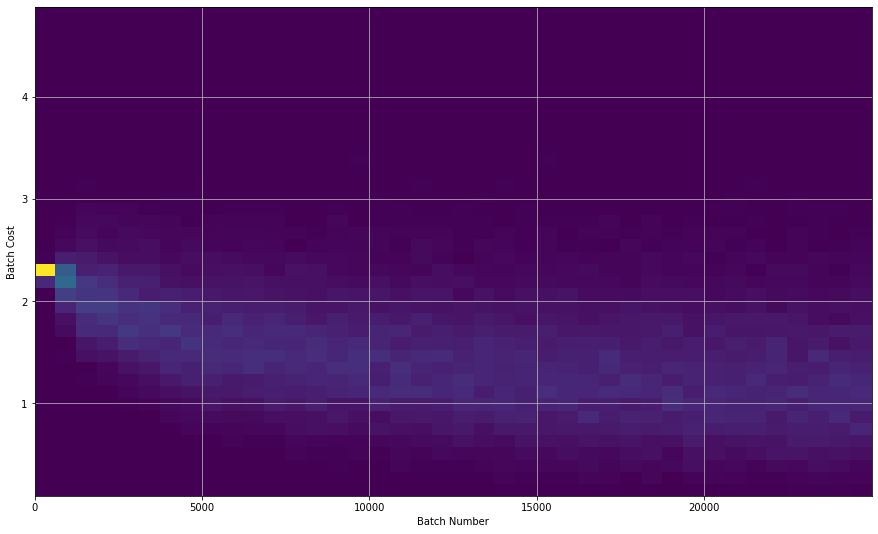

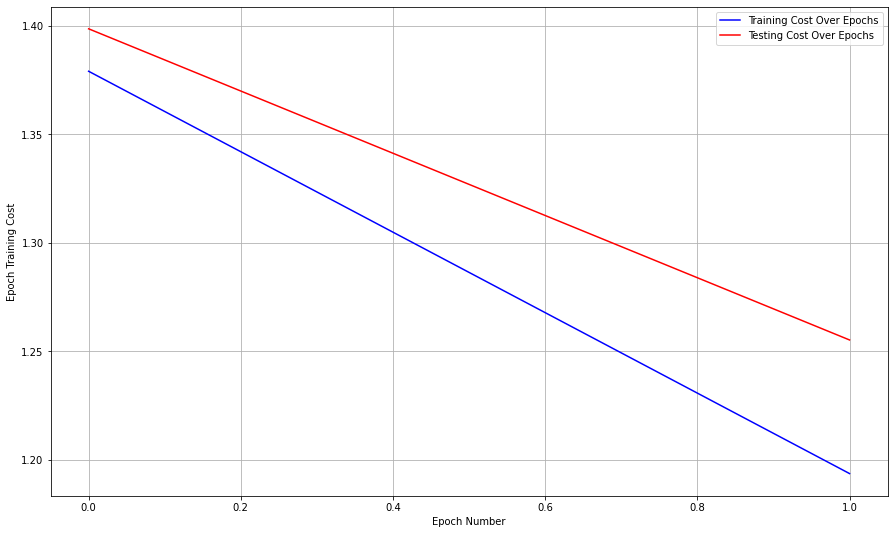

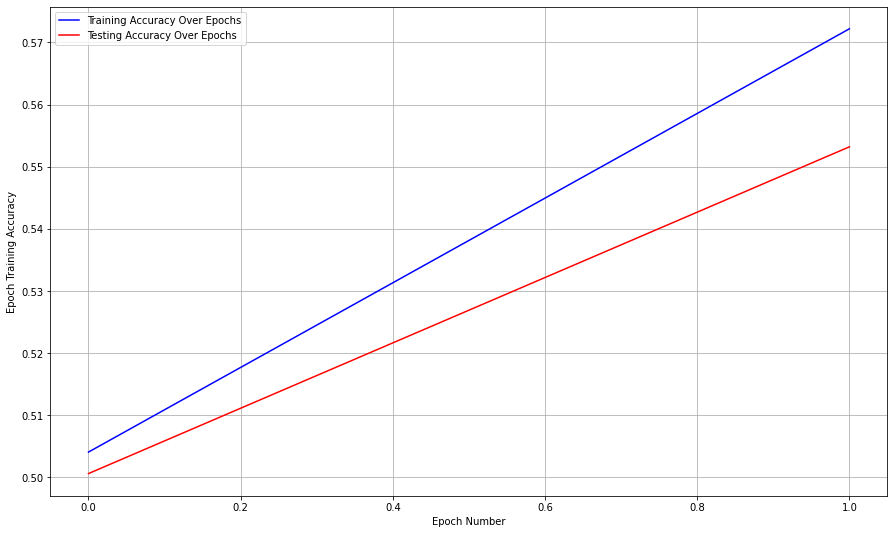

In [0]:
Results_TutorialCNN = trainAndTestConvolutionNetworkProvided( 
    TutorialCNN,
    name="Tutorial Convolutional Neural Network with Tutorial Training Parametres",
    silent=False,
    maxNumberOfEpochs=2,
    batch_size=4,
    number_of_workers=2,
    learning_rate=0.001,
    momentum=0.9
    )
print("Overall Accuracy: "+str(Results_TutorialCNN["overall_accuracy"]))
print("Extraction Time: "+str(Results_TutorialCNN["extraction_time"]))
print("Epoch Times: " +str(Results_TutorialCNN["epoch_times"]))


graphStatistics(Results_TutorialCNN)

####Tutorial CNN Training Parametre Setup no. 2

This was a combination of training paramaetres that yielded better results than those in the tutorial. No changes to the CNN's actual structure here, though. Unfortunately I didn't track all of the numbers I tried out to get to this point, but essentially I was trying out pairs of training parametres and seeing what direction I should move parametres further to calm down the cost over interations graph. Interestingly, having a high batch_size constant calmed the cost over iterations (or batch iterations specifically) graph significantly albeit at the cost of needing more epochs. Also epochs each run faster with higher batch_size so I might prefer this one.

RUNNING TRAINING AND TESTING FUNCTION ON TUTORIAL CONVOLUTIONAL NEURAL NETWORK SETUP 2
Files already downloaded and verified
Files already downloaded and verified
[1 epoch complete]
[2 epoch complete]
[3 epoch complete]
[4 epoch complete]
[5 epoch complete]
[6 epoch complete]
[7 epoch complete]
[8 epoch complete]
[9 epoch complete]
[10 epoch complete]
[11 epoch complete]
[12 epoch complete]
[13 epoch complete]
[14 epoch complete]
[15 epoch complete]
[16 epoch complete]
[17 epoch complete]
[18 epoch complete]
[19 epoch complete]
[20 epoch complete]
[21 epoch complete]
[22 epoch complete]
[23 epoch complete]
[24 epoch complete]
[25 epoch complete]
Training Time: 230.063627243042
Average time per epoch: 9.20254508972168
Training Accuracy of plane : 81 %
Training Accuracy of   car : 92 %
Training Accuracy of  bird : 81 %
Training Accuracy of   cat : 68 %
Training Accuracy of  deer : 76 %
Training Accuracy of   dog : 55 %
Training Accuracy of  frog : 81 %
Training Accuracy of horse : 76 %
T

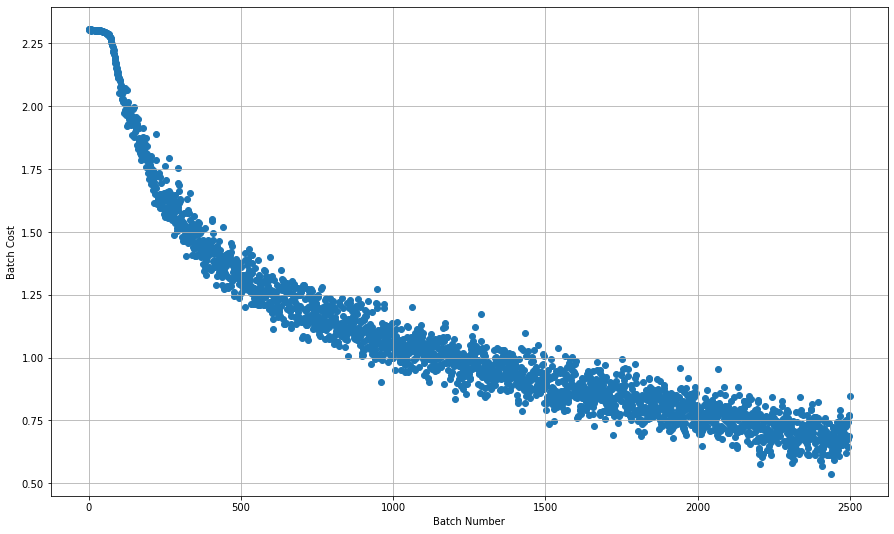

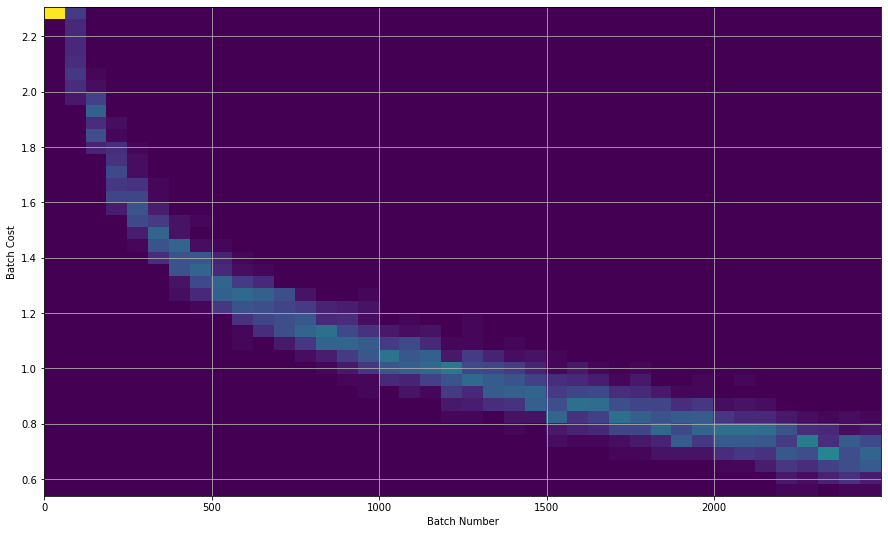

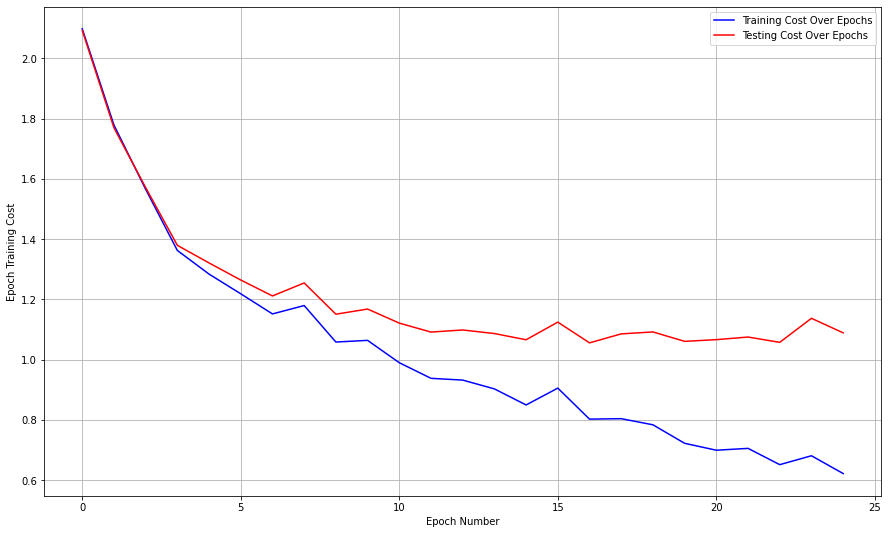

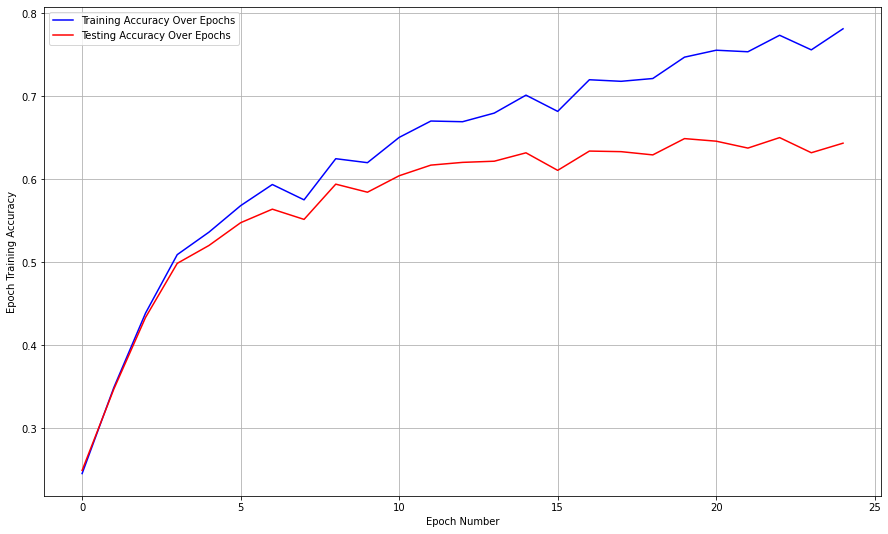

In [0]:
Results_TutorialCNN2 = trainAndTestConvolutionNetworkProvided( 
    TutorialCNN,
    name="Tutorial Convolutional Neural Network setup 2",
    silent=False,
    maxNumberOfEpochs=25,
    batch_size=500,
    learning_rate=0.05,
    momentum=0.75
    )
print("Overall Accuracy: "+str(Results_TutorialCNN2["overall_accuracy"]))
print("Extraction Time: "+str(Results_TutorialCNN2["extraction_time"]))
print("Epoch Times: " +str(Results_TutorialCNN2["epoch_times"]))

graphStatistics(Results_TutorialCNN2)

RUNNING TRAINING AND TESTING FUNCTION ON TUTORIAL CONVOLUTIONAL NEURAL NETWORK SETUP 2 EXTENDED TO 500 EPOCHS
Files already downloaded and verified
Files already downloaded and verified
[1 epoch complete]
[2 epoch complete]
[3 epoch complete]
[4 epoch complete]
[5 epoch complete]
[6 epoch complete]
[7 epoch complete]
[8 epoch complete]
[9 epoch complete]
[10 epoch complete]
[11 epoch complete]
[12 epoch complete]
[13 epoch complete]
[14 epoch complete]
[15 epoch complete]
[16 epoch complete]
[17 epoch complete]
[18 epoch complete]
[19 epoch complete]
[20 epoch complete]
[21 epoch complete]
[22 epoch complete]
[23 epoch complete]
[24 epoch complete]
[25 epoch complete]
[26 epoch complete]
[27 epoch complete]
[28 epoch complete]
[29 epoch complete]
[30 epoch complete]
[31 epoch complete]
[32 epoch complete]
[33 epoch complete]
[34 epoch complete]
[35 epoch complete]
[36 epoch complete]
[37 epoch complete]
[38 epoch complete]
[39 epoch complete]
[40 epoch complete]
[41 epoch complete]
[42

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


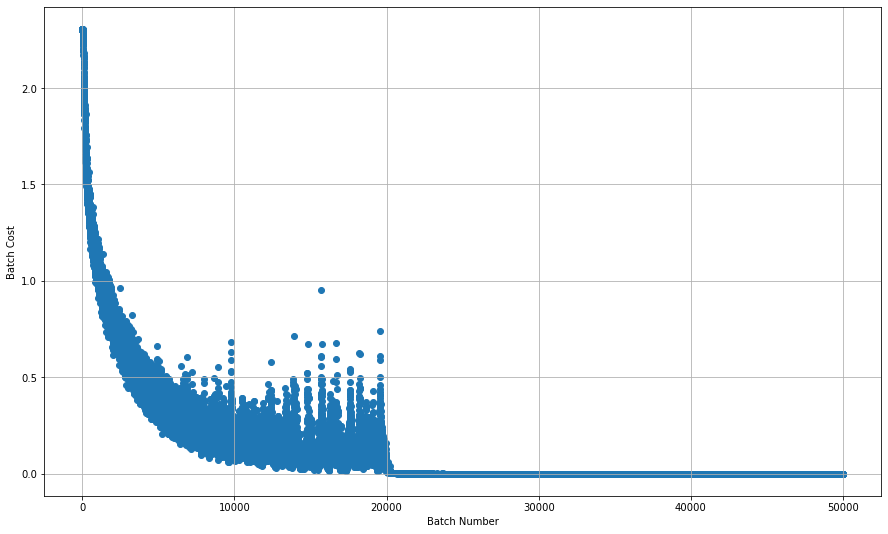

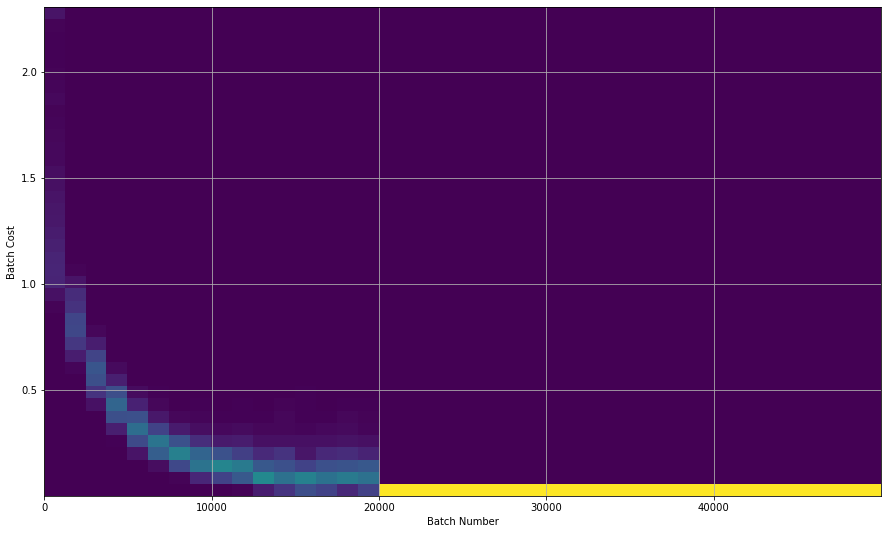

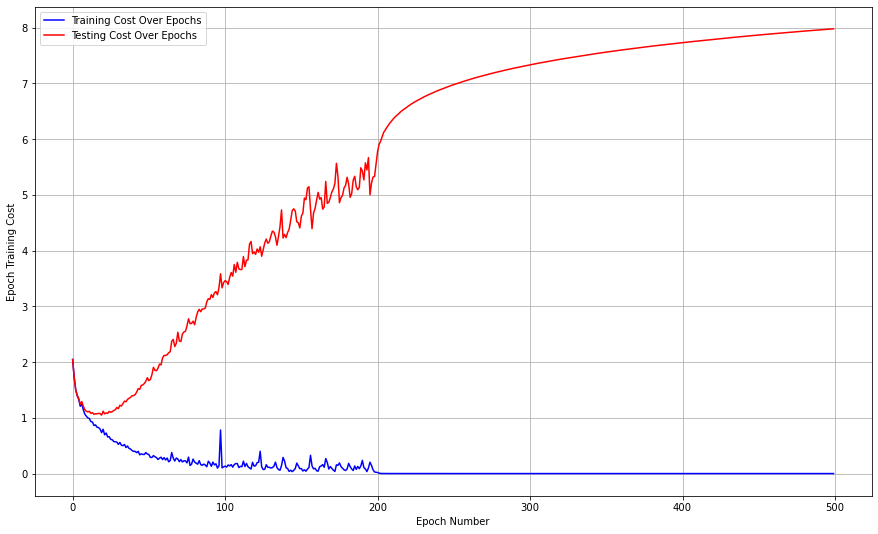

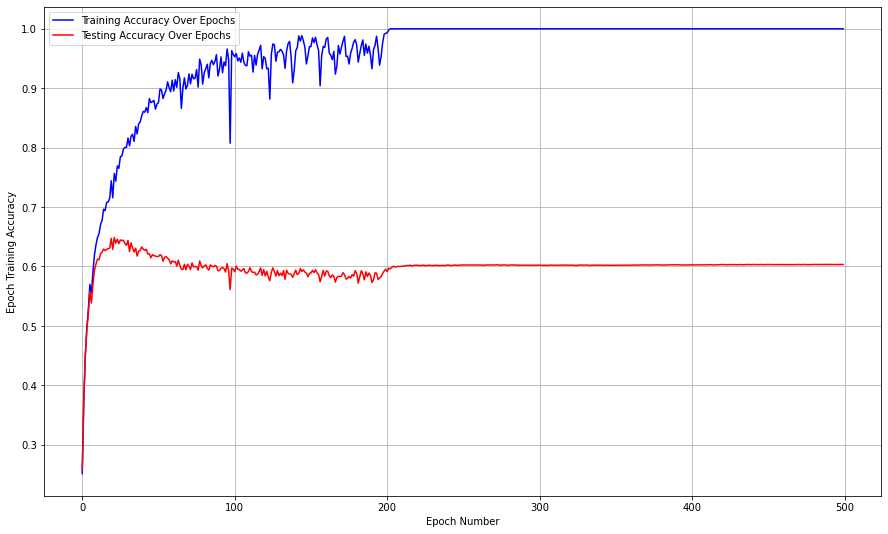

In [0]:
#EXTENDED TO 500 EPOCHS
Results_TutorialCNN2_ext = trainAndTestConvolutionNetworkProvided( 
    TutorialCNN,
    name="Tutorial Convolutional Neural Network setup 2 extended to 500 epochs",
    silent=False,
    maxNumberOfEpochs=500,
    batch_size=500,
    learning_rate=0.05,
    momentum=0.75
    )
print("Overall Accuracy: "+str(Results_TutorialCNN2_ext["overall_accuracy"]))
print("Extraction Time: "+str(Results_TutorialCNN2_ext["extraction_time"]))
print("Epoch Times: " +str(Results_TutorialCNN2_ext["epoch_times"]))

graphStatistics(Results_TutorialCNN2_ext)

####Trying out different loss functions

TutorialCNN Parametre Setup Number 2 at high epoch quantities has yielded the most predictable result among all experiments thus far. As such, I've elected to use this set of parametres to try out other loss functions.

Loss functions in the tutorial convolutional neural network are set up very simply. They are instantiated by their constructor with their name (for example, Cross Entropy Loss function is instanciated as torch.nn.CrossEntropyLoss()) and saved into a variable for use in the training loop later. As such, the trainAndTestConvolutionNetworkProvided() method has an argument specific to substituting the default CrossEntropyLoss instance with another instance - a plug and play means of substituting the loss function with as little additional work done (at the time of coding this block there is less than 24 hours left to complete the entire project; so yes this was a necessary decision). Only 3 other loss functions in torch.nn are able to run without pulling an error like this, though 2 of those other 3 don't seem to do anything. Here's a table of observations as I tried each available loss function. I was, of course, aware that many of these loss functions are structurally not suitable for neural networks.

| Loss Function torch.nn Class Name | Functional | Comments |
| --- | --- | --- |
| L1Loss | No | Does not like taking activation arrays to compare against expected softmax index (tensor size mismatch). |
| MSELoss | No | Does not like taking activation arrays to compare against expected softmax index (tensor size mismatch). |
| CrossEntropyLoss | Yes | Default implementation of analysis function criterion.|
| CTCLoss | No | Missing arguments 'input_lengths' and 'target_lengths' error |
| NLLLoss | Baited | Doesn't error but doesn't optimize either. Losses recorded as NaN |
| NLLLoss2D | Baited | Doesn't error but doesn't optimize either. Losses recorded as NaN. |
| PoissonNLLLoss | No | Tensor size mismatch error. |
| KLDivLoss | No | Errors ""log_cuda" not implemented for 'Long'" |
| BCELoss | No | Does not like taking activation arrays to compare against expected softmax index (shape mismatch). |
| BCEWithLogitsLoss | No | Does not like taking activation arrays to compare against expected softmax index (shape mismatch). |
| MarginRankingLoss | No | Forward() missing an additional 'target' argument supposedly |
| HingeEmbeddingLoss | No | Does not like taking activation arrays to compare against expected softmax index (tensor size mismatch). |
| MultiLabelMarginLoss | No | Weird error about some inconsistent target size. |
| SmoothL1Loss | No | Does not like taking activation arrays to compare against expected softmax index (tensor size mismatch). |
| SoftMarginLoss | No | Does not work with arrays in second argument |
| MultiLabelSoftMarginLoss | No | Does not like taking activation arrays to compare against expected softmax index (tensor size mismatch). |
| CosineEmbeddingLoss | No | Foward() missing an additional 'target' argument supposedly |
| MultiMarginLoss | Yes | Works in plug-and-play fashion! Instance can directly substitute instance of CrossEntropyLoss. |
| TripletMarginLoss | No | Foward() missing an additional 'negative' argument supposedly |



TutorialCNN with Parametre Setup no. 2 extended to 250 epochs using the MULTI MARGIN LOSS FUNCTION and not the triple margin loss function as the string incorrectly say. Following this section of code is the exact same configuration using the original CrossEntropyLoss loss function for direct comparison.

RUNNING TRAINING AND TESTING FUNCTION ON TUTORIAL CONVOLUTIONAL NEURAL NETWORK SETUP 2 EXTENDED TO 250 EPOCHS USING TRIPLE MARGIN LOSS FUNCTION
Files already downloaded and verified
Files already downloaded and verified
[1 epoch complete]
[2 epoch complete]
[3 epoch complete]
[4 epoch complete]
[5 epoch complete]
[6 epoch complete]
[7 epoch complete]
[8 epoch complete]
[9 epoch complete]
[10 epoch complete]
[11 epoch complete]
[12 epoch complete]
[13 epoch complete]
[14 epoch complete]
[15 epoch complete]
[16 epoch complete]
[17 epoch complete]
[18 epoch complete]
[19 epoch complete]
[20 epoch complete]
[21 epoch complete]
[22 epoch complete]
[23 epoch complete]
[24 epoch complete]
[25 epoch complete]
[26 epoch complete]
[27 epoch complete]
[28 epoch complete]
[29 epoch complete]
[30 epoch complete]
[31 epoch complete]
[32 epoch complete]
[33 epoch complete]
[34 epoch complete]
[35 epoch complete]
[36 epoch complete]
[37 epoch complete]
[38 epoch complete]
[39 epoch complete]
[40 epoch

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


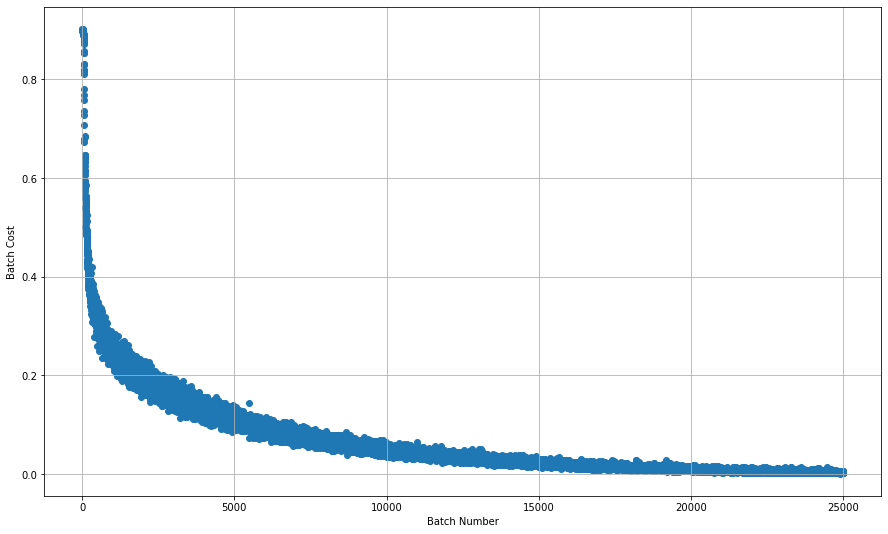

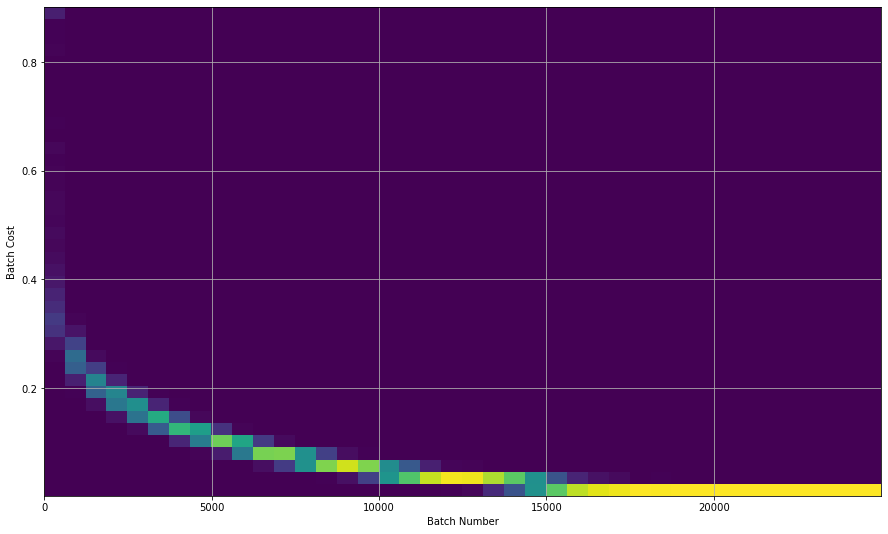

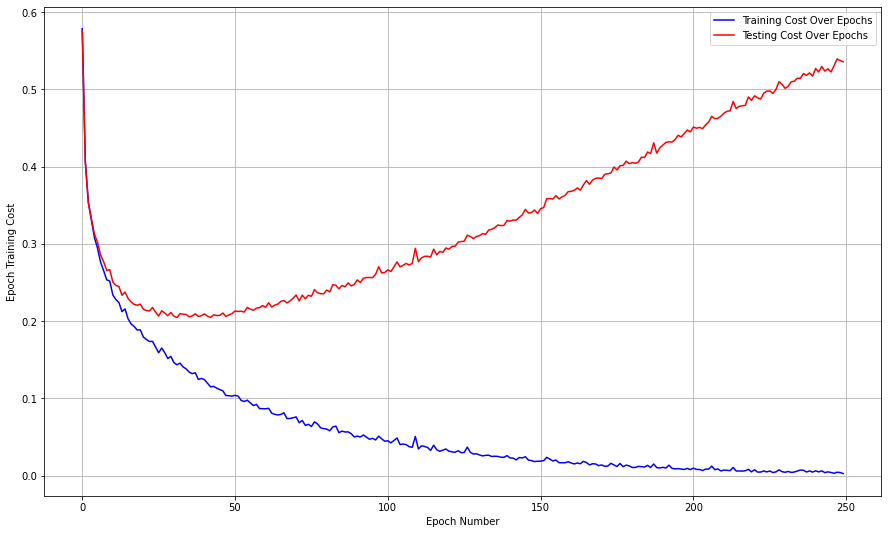

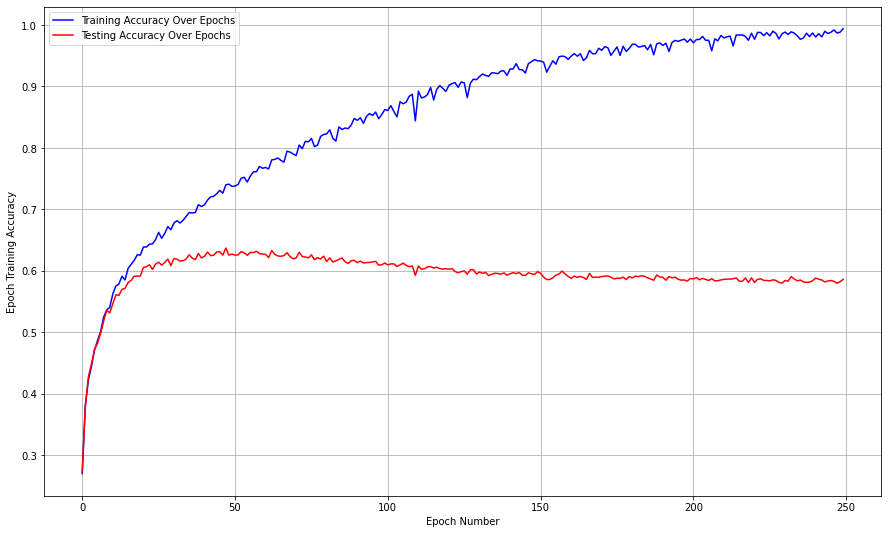

In [0]:
Results_TutorialCNN2_ext_TripleMarginLoss = trainAndTestConvolutionNetworkProvided( 
    TutorialCNN,
    name="Tutorial Convolutional Neural Network setup 2 extended to 250 epochs using Triple Margin Loss Function",
    silent=False,
    maxNumberOfEpochs=250,
    batch_size=500,
    learning_rate=0.05,
    momentum=0.75,
    criterion=nn.MultiMarginLoss()
    )
print("Overall Accuracy: "+str(Results_TutorialCNN2_ext_TripleMarginLoss["overall_accuracy"]))
print("Extraction Time: "+str(Results_TutorialCNN2_ext_TripleMarginLoss["extraction_time"]))
print("Epoch Times: " +str(Results_TutorialCNN2_ext_TripleMarginLoss["epoch_times"]))

graphStatistics(Results_TutorialCNN2_ext_TripleMarginLoss)

In [0]:
Results_TutorialCNN2_ext_CrossEntropyLoss = trainAndTestConvolutionNetworkProvided( 
    TutorialCNN,
    name="Tutorial Convolutional Neural Network setup 2 extended to 250 epochs using Cross Entropy Loss Function",
    silent=False,
    maxNumberOfEpochs=250,
    batch_size=500,
    learning_rate=0.05,
    momentum=0.75,
    criterion=nn.CrossEntropyLoss()
    )
print("Overall Accuracy: "+str(Results_TutorialCNN2_ext_CrossEntropyLoss["overall_accuracy"]))
print("Extraction Time: "+str(Results_TutorialCNN2_ext_CrossEntropyLoss["extraction_time"]))
print("Epoch Times: " +str(Results_TutorialCNN2_ext_CrossEntropyLoss["epoch_times"]))

graphStatistics(Results_TutorialCNN2_ext_CrossEntropyLoss)

RUNNING TRAINING AND TESTING FUNCTION ON TUTORIAL CONVOLUTIONAL NEURAL NETWORK SETUP 2 EXTENDED TO 250 EPOCHS USING CROSS ENTROPY LOSS FUNCTION
Files already downloaded and verified
Files already downloaded and verified
[1 epoch complete]
[2 epoch complete]
[3 epoch complete]
[4 epoch complete]
[5 epoch complete]
[6 epoch complete]
[7 epoch complete]
[8 epoch complete]
[9 epoch complete]
[10 epoch complete]
[11 epoch complete]
[12 epoch complete]
[13 epoch complete]
[14 epoch complete]
[15 epoch complete]
[16 epoch complete]
[17 epoch complete]
[18 epoch complete]
[19 epoch complete]
[20 epoch complete]
[21 epoch complete]
[22 epoch complete]
[23 epoch complete]
[24 epoch complete]
[25 epoch complete]
[26 epoch complete]
[27 epoch complete]
[28 epoch complete]
[29 epoch complete]
[30 epoch complete]
[31 epoch complete]
[32 epoch complete]
[33 epoch complete]
[34 epoch complete]
[35 epoch complete]
[36 epoch complete]
[37 epoch complete]
[38 epoch complete]
[39 epoch complete]
[40 epoch

####Tutorial CNN Training Parametre Setup no. 3

Here I see how well things go if I extremify the batch_size. I change maxNumberOfEpochs to give it more iterations to train on batches.

RUNNING TRAINING AND TESTING FUNCTION ON TUTORIAL CONVOLUTIONAL NEURAL NETWORK SETUP 3
Files already downloaded and verified
Files already downloaded and verified
[1 epoch complete]
[2 epoch complete]
[3 epoch complete]
[4 epoch complete]
[5 epoch complete]
[6 epoch complete]
[7 epoch complete]
[8 epoch complete]
[9 epoch complete]
[10 epoch complete]
[11 epoch complete]
[12 epoch complete]
[13 epoch complete]
[14 epoch complete]
[15 epoch complete]
[16 epoch complete]
[17 epoch complete]
[18 epoch complete]
[19 epoch complete]
[20 epoch complete]
[21 epoch complete]
[22 epoch complete]
[23 epoch complete]
[24 epoch complete]
[25 epoch complete]
Training Time: 232.81250882148743
Average time per epoch: 9.312500352859496
Training Accuracy of plane : 68 %
Training Accuracy of   car : 76 %
Training Accuracy of  bird : 50 %
Training Accuracy of   cat : 42 %
Training Accuracy of  deer : 42 %
Training Accuracy of   dog : 47 %
Training Accuracy of  frog : 72 %
Training Accuracy of horse : 63 

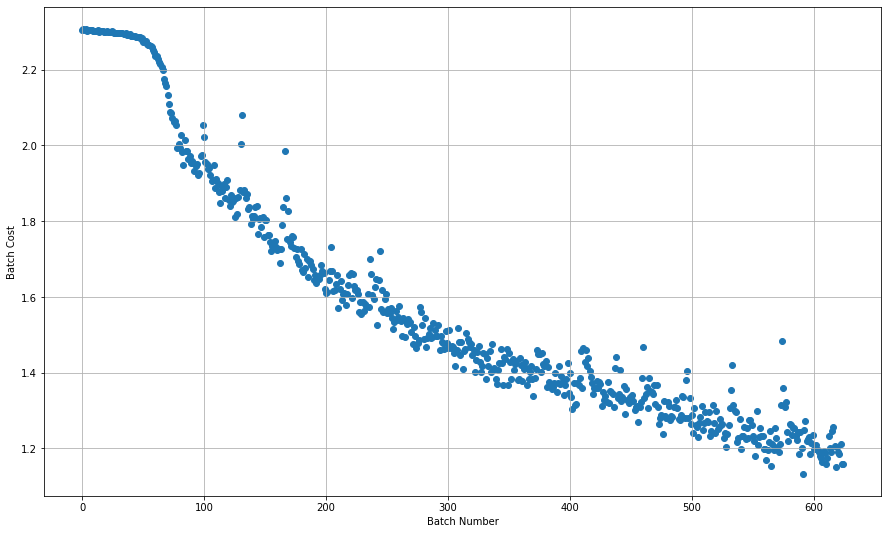

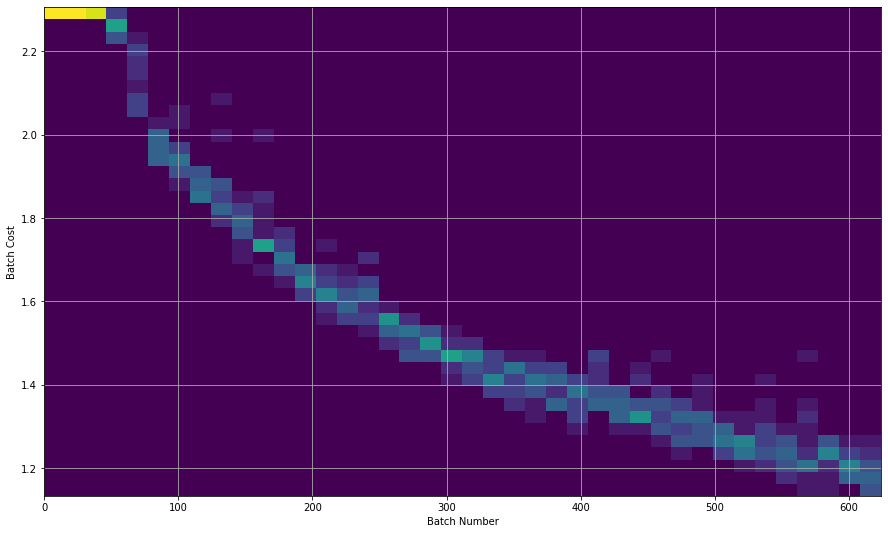

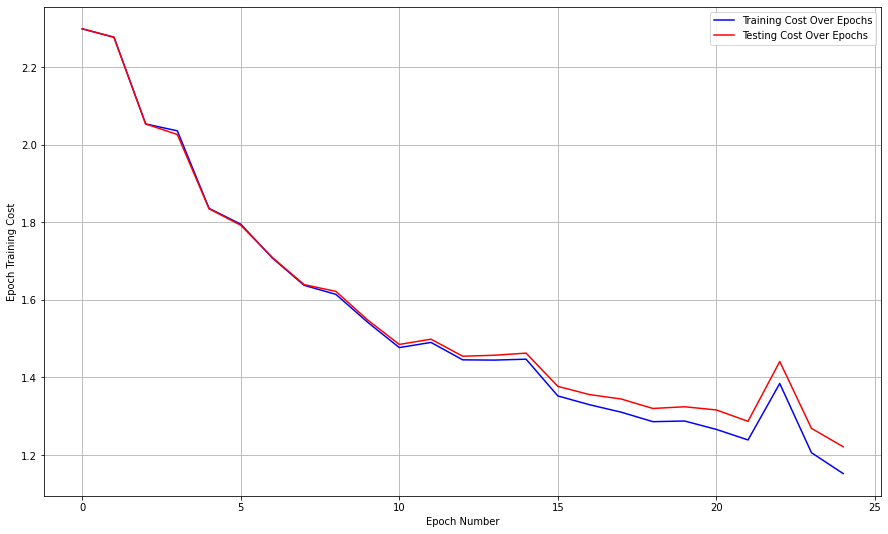

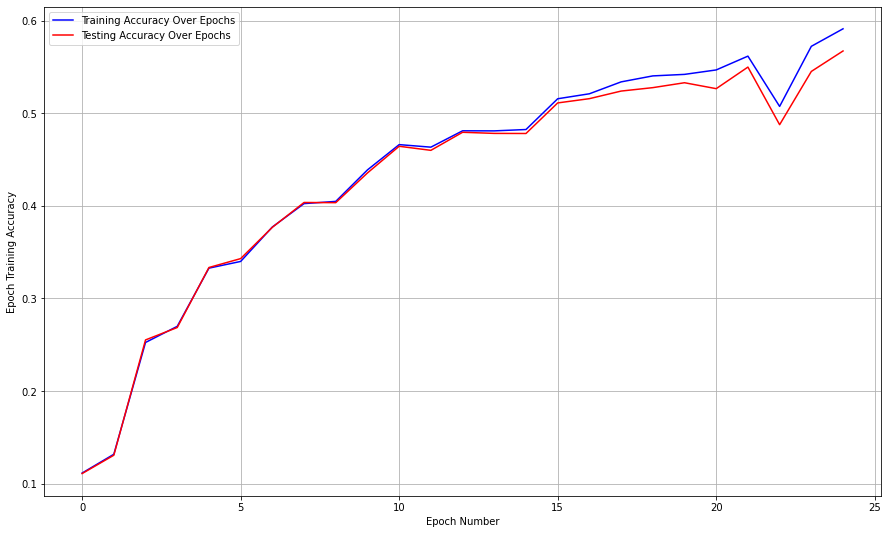

In [0]:
Results_TutorialCNN3 = trainAndTestConvolutionNetworkProvided( 
    TutorialCNN,
    name="Tutorial Convolutional Neural Network setup 3",
    silent=False,
    maxNumberOfEpochs=25,
    batch_size=2000,
    learning_rate=0.05,
    momentum=0.75
    )
print("Overall Accuracy: "+str(Results_TutorialCNN3["overall_accuracy"]))
print("Extraction Time: "+str(Results_TutorialCNN3["extraction_time"]))
print("Epoch Times: " +str(Results_TutorialCNN3["epoch_times"]))

graphStatistics(Results_TutorialCNN3)

RUNNING TRAINING AND TESTING FUNCTION ON TUTORIAL CONVOLUTIONAL NEURAL NETWORK SETUP 3 EXTENDED TO 200 EPOCHS
Files already downloaded and verified
Files already downloaded and verified
[1 epoch complete]
[2 epoch complete]
[3 epoch complete]
[4 epoch complete]
[5 epoch complete]
[6 epoch complete]
[7 epoch complete]
[8 epoch complete]
[9 epoch complete]
[10 epoch complete]
[11 epoch complete]
[12 epoch complete]
[13 epoch complete]
[14 epoch complete]
[15 epoch complete]
[16 epoch complete]
[17 epoch complete]
[18 epoch complete]
[19 epoch complete]
[20 epoch complete]
[21 epoch complete]
[22 epoch complete]
[23 epoch complete]
[24 epoch complete]
[25 epoch complete]
[26 epoch complete]
[27 epoch complete]
[28 epoch complete]
[29 epoch complete]
[30 epoch complete]
[31 epoch complete]
[32 epoch complete]
[33 epoch complete]
[34 epoch complete]
[35 epoch complete]
[36 epoch complete]
[37 epoch complete]
[38 epoch complete]
[39 epoch complete]
[40 epoch complete]
[41 epoch complete]
[42

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


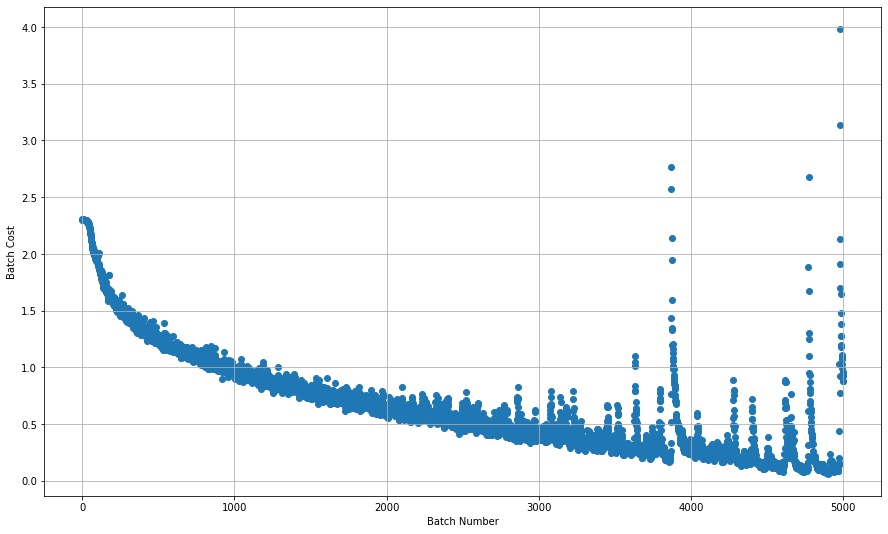

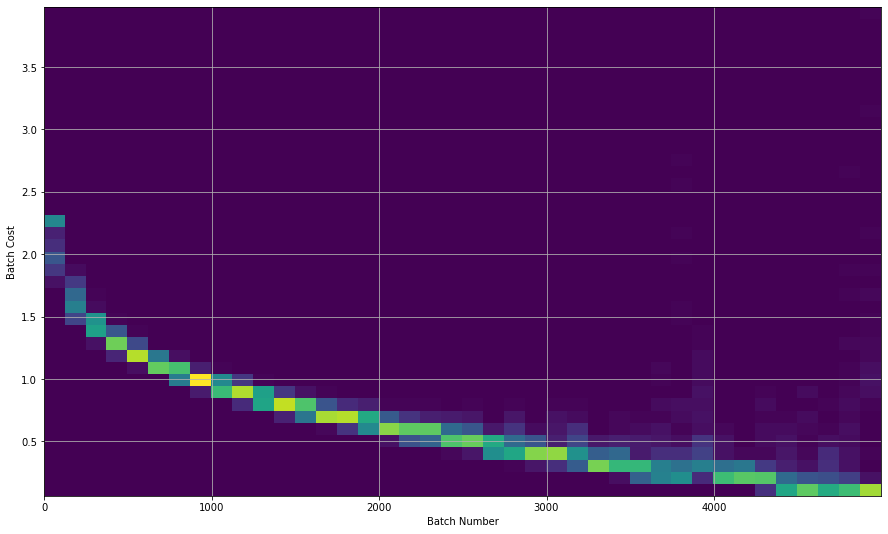

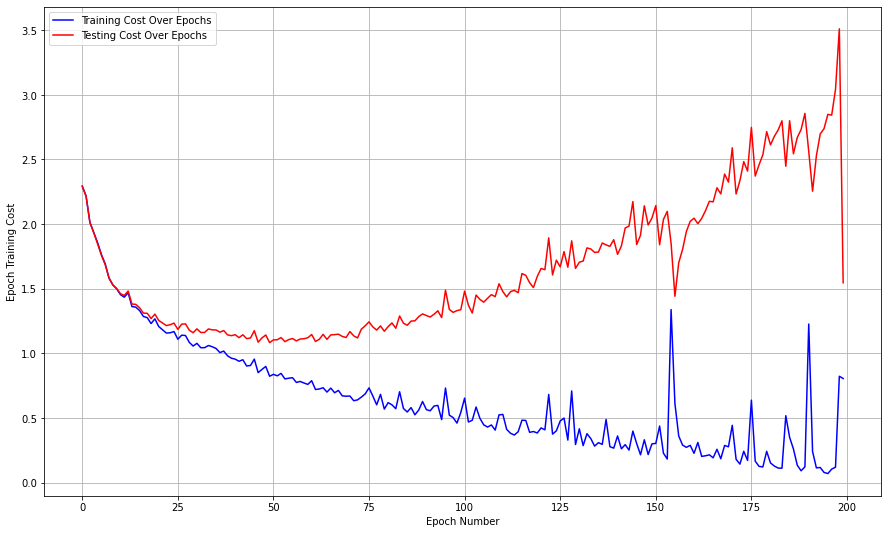

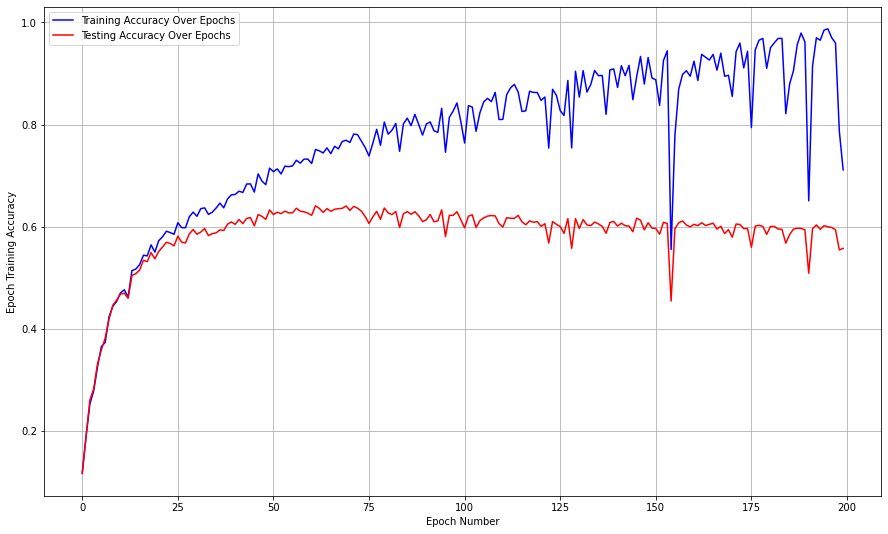

In [0]:
#EXTENDED TO 200 EPOCHS
Results_TutorialCNN3_ext = trainAndTestConvolutionNetworkProvided( 
    TutorialCNN,
    name="Tutorial Convolutional Neural Network setup 3 extended to 200 epochs",
    silent=False,
    maxNumberOfEpochs=200,
    batch_size=2000,
    learning_rate=0.05,
    momentum=0.75
    )
print("Overall Accuracy: "+str(Results_TutorialCNN3_ext["overall_accuracy"]))
print("Extraction Time: "+str(Results_TutorialCNN3_ext["extraction_time"]))
print("Epoch Times: " +str(Results_TutorialCNN3_ext["epoch_times"]))

graphStatistics(Results_TutorialCNN3_ext)

####Tutorial CNN Training Parametre Setup no. 4

Here I see how well I can get the system working on as small batch sizes as possible.

RUNNING TRAINING AND TESTING FUNCTION ON TUTORIAL CONVOLUTIONAL NEURAL NETWORK SETUP 4


14.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

40.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

58.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

91.0%IOPub

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
[1, 2000] loss: 2.153
[1, 4000] loss: 1.803
[1, 6000] loss: 1.637
[1, 8000] loss: 1.555
[1,10000] loss: 1.470
[1,12000] loss: 1.420
[1 epoch complete]
Training Time: 51.25838232040405
Average time per epoch: 51.25838232040405
Training Accuracy of plane : 49 %
Training Accuracy of   car : 63 %
Training Accuracy of  bird : 27 %
Training Accuracy of   cat : 26 %
Training Accuracy of  deer : 17 %
Training Accuracy of   dog : 28 %
Training Accuracy of  frog : 62 %
Training Accuracy of horse : 84 %
Training Accuracy of  ship : 47 %
Training Accuracy of truck : 70 %
Training Accuracy overall: 47 %
Accuracy of plane : 50 %
Accuracy of   car : 62 %
Accuracy of  bird : 28 %
Accuracy of   cat : 23 %
Accuracy of  deer : 15 %
Accuracy of   dog : 27 %
Accuracy of  frog : 63 %
Accuracy of horse : 83 %
Accuracy of  ship : 46 %
Accuracy of truck : 68 %
Accuracy overall: 46 %
Overall Accuracy: 0.4692
Extraction Time

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Files already downloaded and verified
Files already downloaded and verified
[1, 2000] loss: 2.172
[1, 4000] loss: 1.904
[1, 6000] loss: 1.741
[1, 8000] loss: 1.673
[1,10000] loss: 1.595
[1,12000] loss: 1.590
[1,14000] loss: 1.549
[1,16000] loss: 1.541
[1,18000] loss: 1.512
[1,20000] loss: 1.507
[1,22000] loss: 1.468
[1,24000] loss: 1.486
[1 epoch complete]
Training Time: 93.44769334793091
Average time per epoch: 93.44769334793091
Training Accuracy of plane : 49 %
Training Accuracy of   car : 62 %
Training Accuracy of  bird : 51 %
Training Accuracy of   cat : 28 %
Training Accuracy of  deer : 25 %
Training Accuracy of   dog : 49 %
Training Accuracy of  frog : 52 %
Training Accuracy of horse : 40 %
Training Accuracy of  ship : 76 %
Training Accuracy of truck : 54 %
Training Accuracy overall: 49 %
Accuracy of plane : 49 %
Accuracy of   car : 62 %
Accuracy of  bird : 51 %
Accuracy of   cat : 28 %
Accuracy of  deer : 23 %
Accuracy of   dog : 49 %
Accuracy of  frog : 51 %
Accuracy of horse :

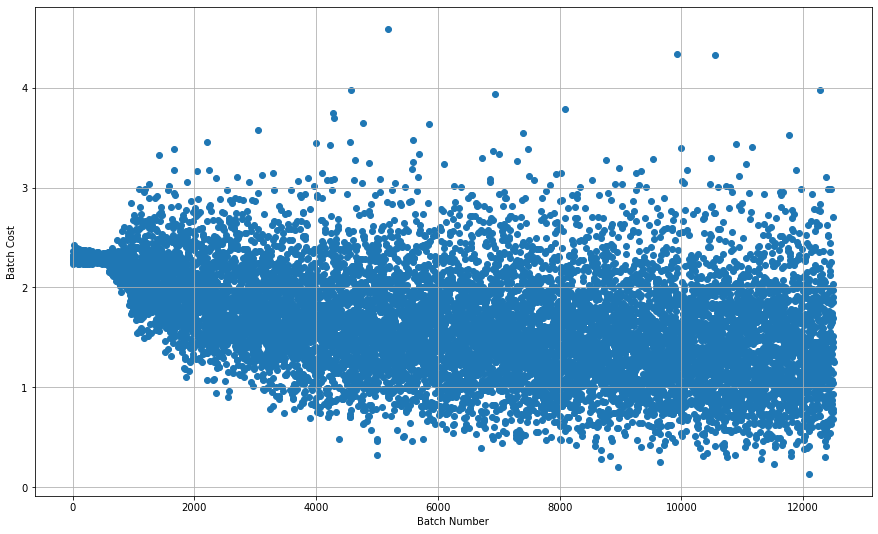

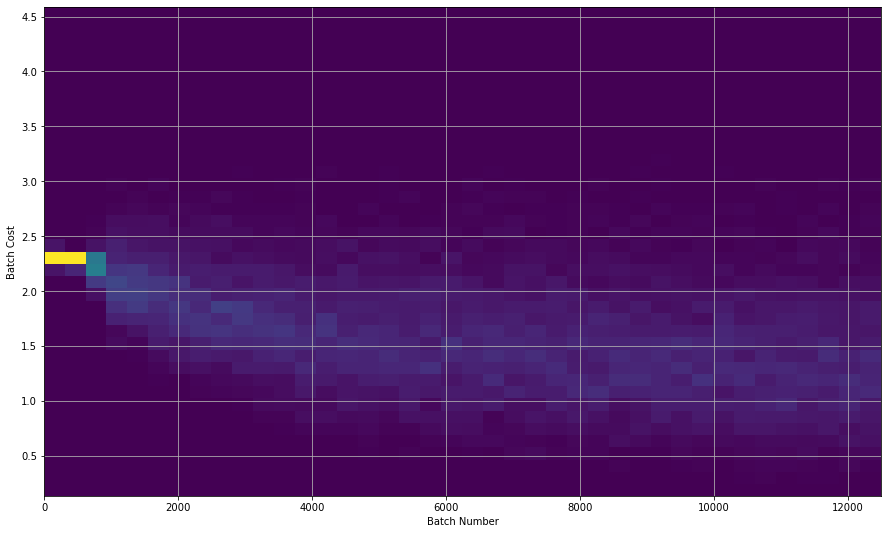

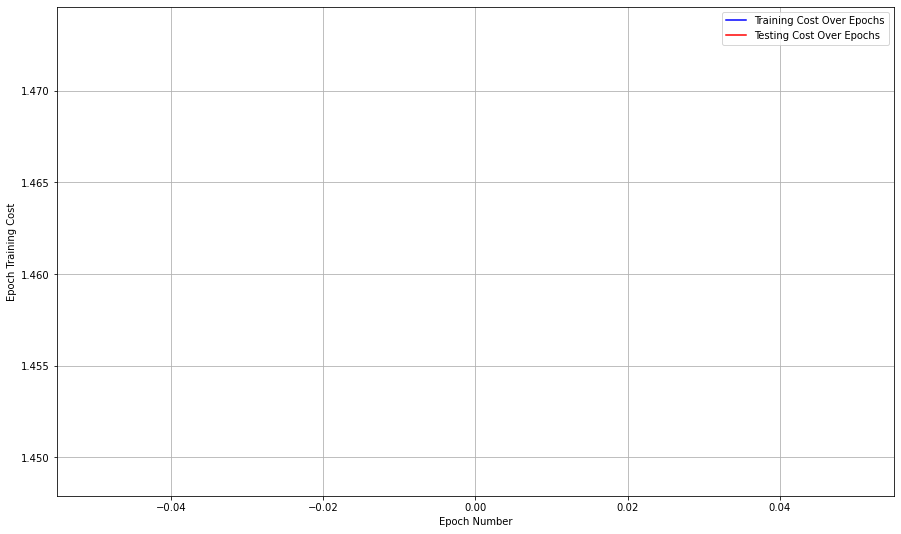

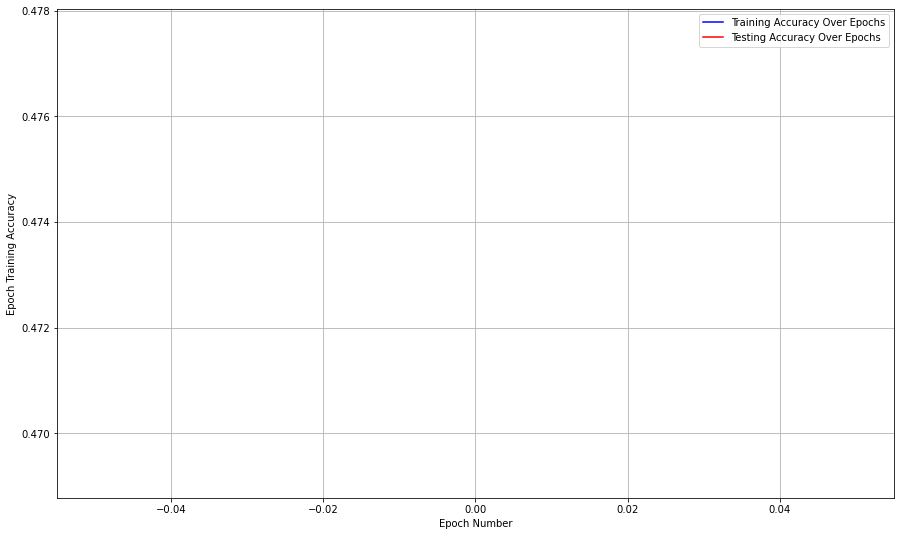

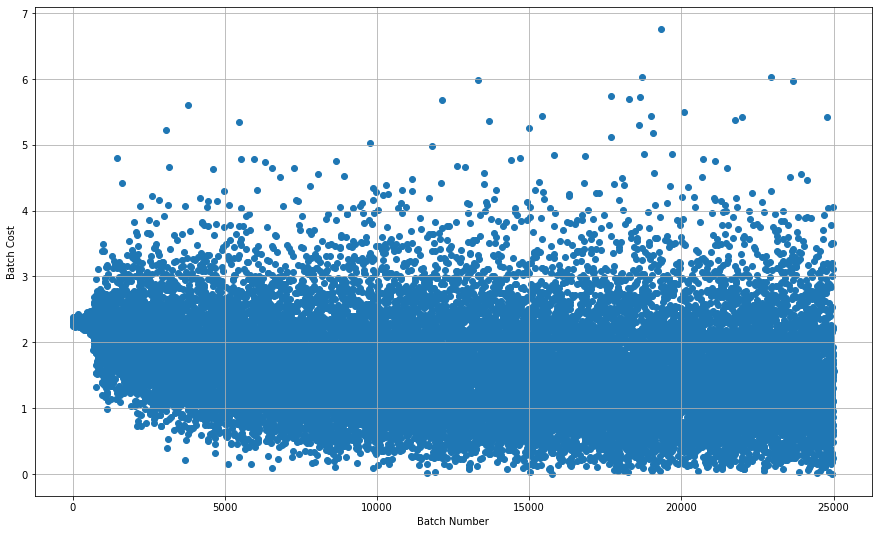

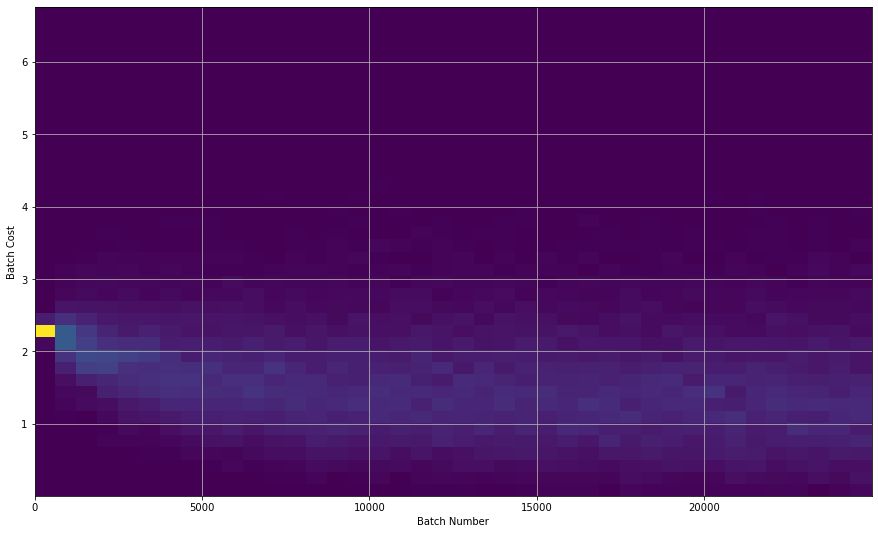

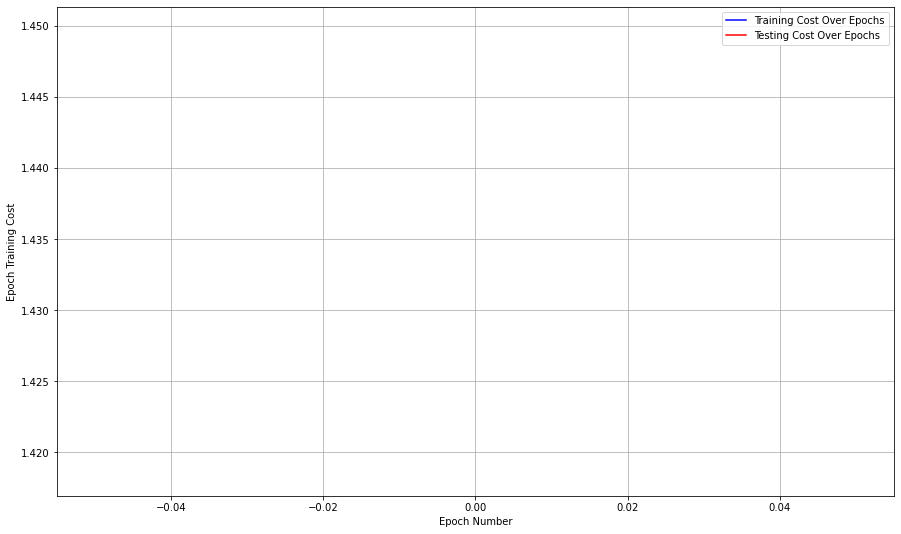

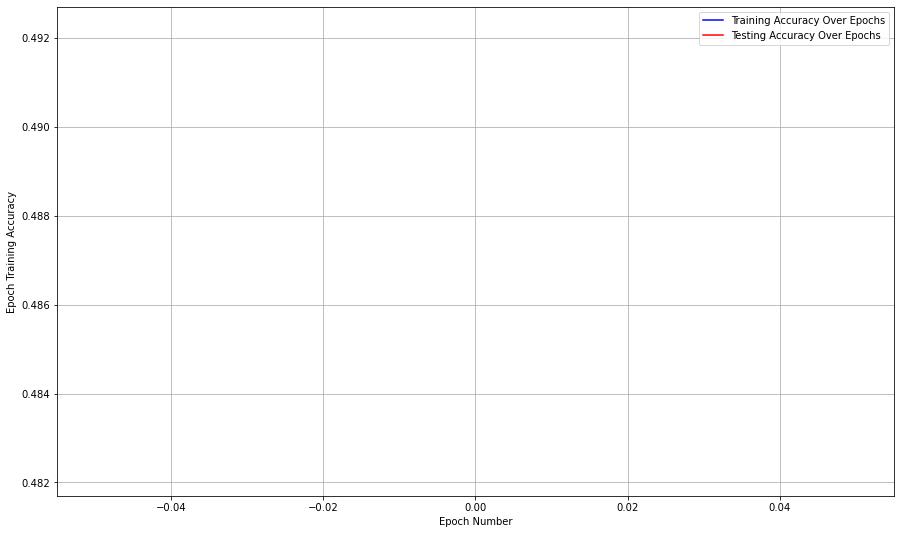

In [0]:
Results_TutorialCNN4 = trainAndTestConvolutionNetworkProvided( 
    TutorialCNN,
    name="Tutorial Convolutional Neural Network setup 4",
    silent=False,
    maxNumberOfEpochs=1,
    batch_size=4,
    learning_rate=1e-2,
    momentum=0.3
    )
print("Overall Accuracy: "+str(Results_TutorialCNN4["overall_accuracy"]))
print("Extraction Time: "+str(Results_TutorialCNN4["extraction_time"]))
print("Epoch Times: " +str(Results_TutorialCNN4["epoch_times"]))

graphStatistics(Results_TutorialCNN4)

Results_TutorialCNN4 = trainAndTestConvolutionNetworkProvided( 
    TutorialCNN,
    name="Tutorial Convolutional Neural Network setup 4 deviating",
    silent=False,
    maxNumberOfEpochs=1,
    batch_size=2,
    learning_rate=1e-2,
    momentum=0.3
    )
print("Overall Accuracy: "+str(Results_TutorialCNN4["overall_accuracy"]))
print("Extraction Time: "+str(Results_TutorialCNN4["extraction_time"]))
print("Epoch Times: " +str(Results_TutorialCNN4["epoch_times"]))

graphStatistics(Results_TutorialCNN4)

#### SmallerCNN Training Parametre Setup no. 1

RUNNING TRAINING AND TESTING FUNCTION ON SMALLER CONVOLUTIONAL NEURAL NETWORK TRAINED AT BATCH SIZE 2000 LR0.05 MOM0.75 EPOCHS200.
Files already downloaded and verified
Files already downloaded and verified
[1 epoch complete]
[2 epoch complete]
[3 epoch complete]
[4 epoch complete]
[5 epoch complete]
[6 epoch complete]
[7 epoch complete]
[8 epoch complete]
[9 epoch complete]
[10 epoch complete]
[11 epoch complete]
[12 epoch complete]
[13 epoch complete]
[14 epoch complete]
[15 epoch complete]
[16 epoch complete]
[17 epoch complete]
[18 epoch complete]
[19 epoch complete]
[20 epoch complete]
[21 epoch complete]
[22 epoch complete]
[23 epoch complete]
[24 epoch complete]
[25 epoch complete]
[26 epoch complete]
[27 epoch complete]
[28 epoch complete]
[29 epoch complete]
[30 epoch complete]
[31 epoch complete]
[32 epoch complete]
[33 epoch complete]
[34 epoch complete]
[35 epoch complete]
[36 epoch complete]
[37 epoch complete]
[38 epoch complete]
[39 epoch complete]
[40 epoch complete]
[4

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


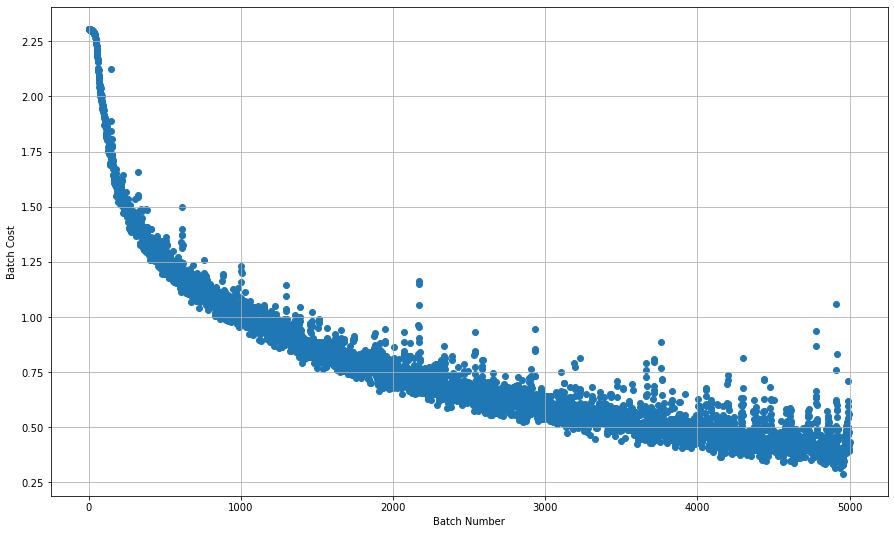

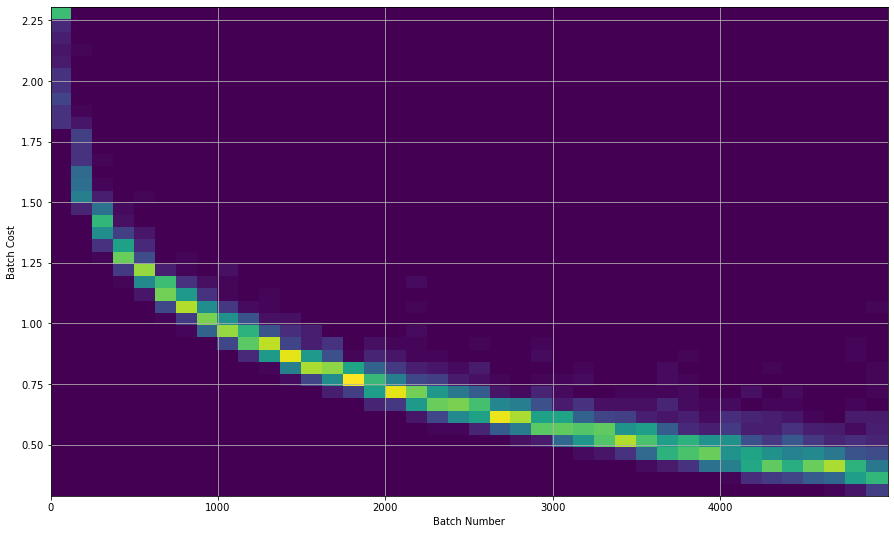

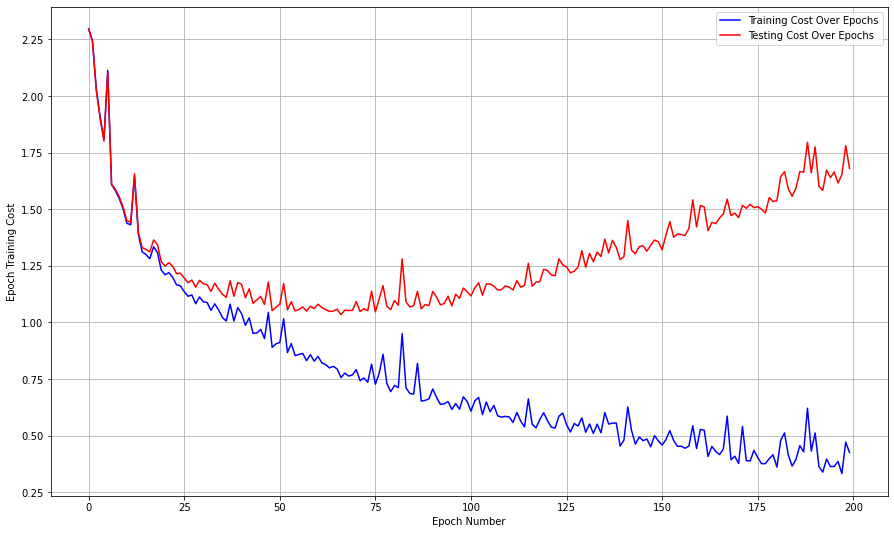

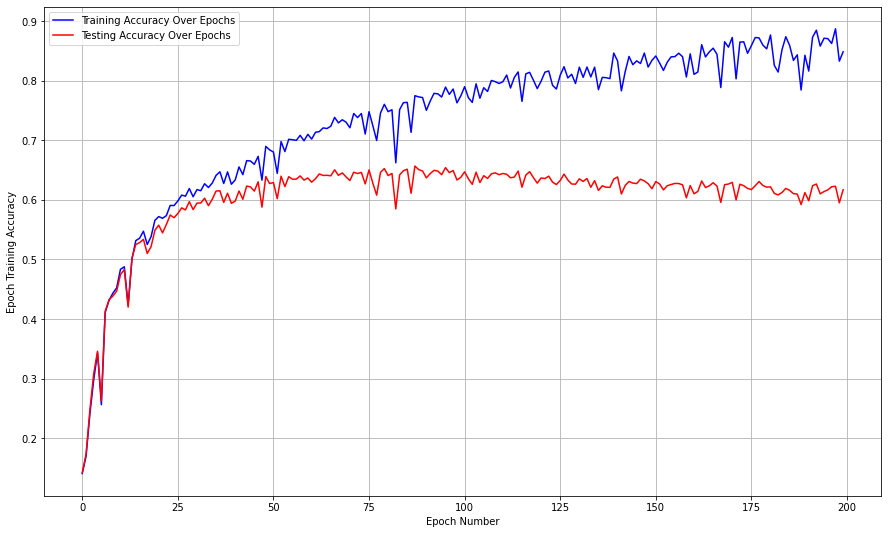

In [0]:
Results_SmallerCNN1 = trainAndTestConvolutionNetworkProvided( 
    SmallerCNN,
    name="Smaller Convolutional Neural Network trained at batch size 2000 lr0.05 mom0.75 epochs200.",
    silent=False,
    maxNumberOfEpochs=200,
    batch_size=2000,
    learning_rate=0.05,
    momentum=0.75
    )
print("Overall Accuracy: "+str(Results_SmallerCNN1["overall_accuracy"]))
print("Extraction Time: "+str(Results_SmallerCNN1["extraction_time"]))
print("Epoch Times: " +str(Results_SmallerCNN1["epoch_times"]))

graphStatistics(Results_SmallerCNN1)

#### TinyCNN Training Parametre Setup no. 1

RUNNING TRAINING AND TESTING FUNCTION ON TINY CONVOLUTIONAL NEURAL NETWORK TRAINED AT BATCH SIZE 2000 LR0.05 MOM0.75 EPOCHS200.
Files already downloaded and verified
Files already downloaded and verified
[1 epoch complete]
[2 epoch complete]
[3 epoch complete]
[4 epoch complete]
[5 epoch complete]
[6 epoch complete]
[7 epoch complete]
[8 epoch complete]
[9 epoch complete]
[10 epoch complete]
[11 epoch complete]
[12 epoch complete]
[13 epoch complete]
[14 epoch complete]
[15 epoch complete]
[16 epoch complete]
[17 epoch complete]
[18 epoch complete]
[19 epoch complete]
[20 epoch complete]
[21 epoch complete]
[22 epoch complete]
[23 epoch complete]
[24 epoch complete]
[25 epoch complete]
[26 epoch complete]
[27 epoch complete]
[28 epoch complete]
[29 epoch complete]
[30 epoch complete]
[31 epoch complete]
[32 epoch complete]
[33 epoch complete]
[34 epoch complete]
[35 epoch complete]
[36 epoch complete]
[37 epoch complete]
[38 epoch complete]
[39 epoch complete]
[40 epoch complete]
[41 e

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


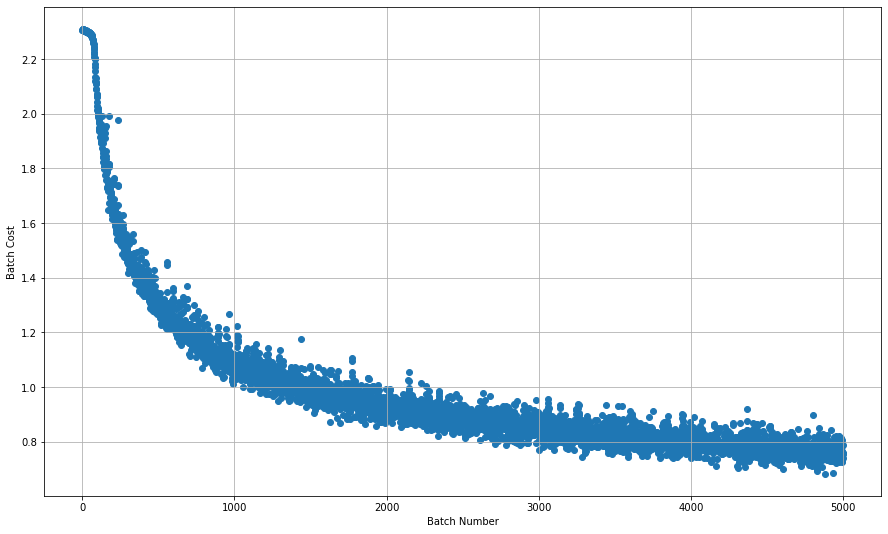

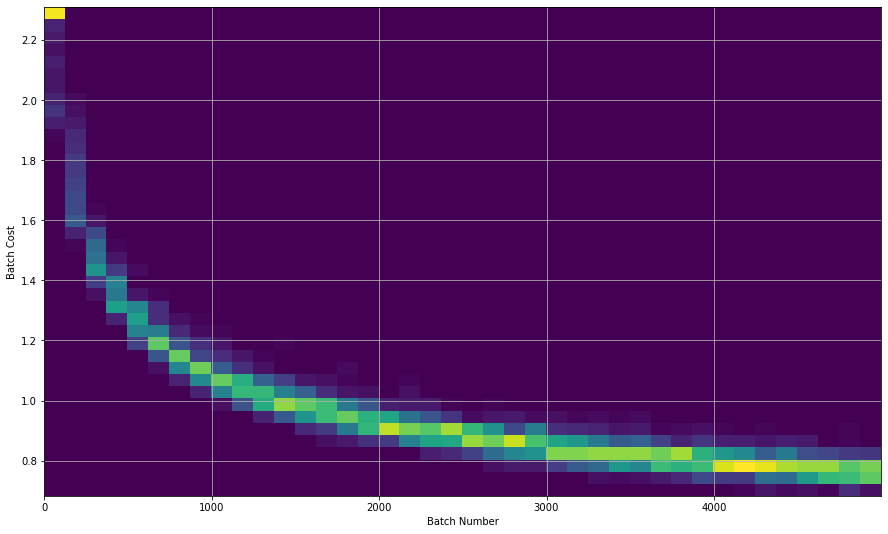

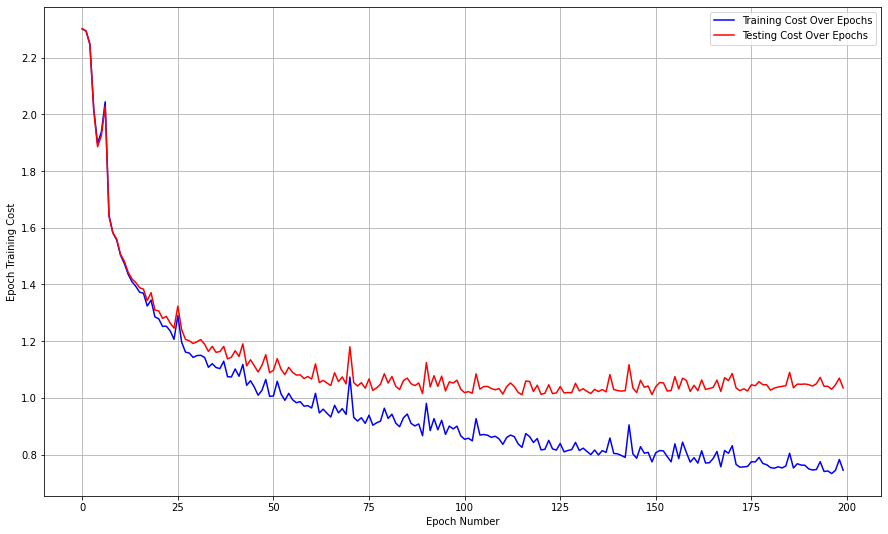

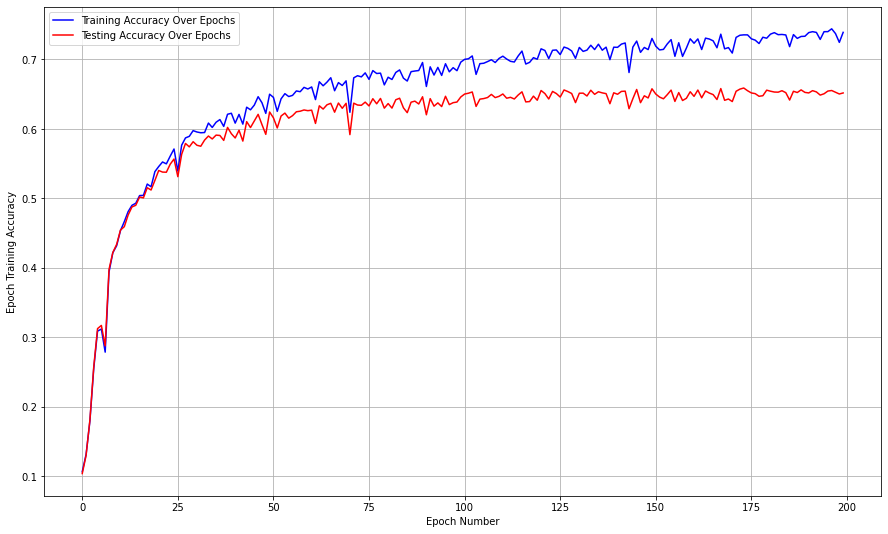

In [0]:
Results_TinyCNN1 = trainAndTestConvolutionNetworkProvided( 
    TinyCNN,
    name="Tiny Convolutional Neural Network trained at batch size 2000 lr0.05 mom0.75 epochs200.",
    silent=False,
    maxNumberOfEpochs=200,
    batch_size=2000,
    learning_rate=0.05,
    momentum=0.75
    )
print("Overall Accuracy: "+str(Results_TinyCNN1["overall_accuracy"]))
print("Extraction Time: "+str(Results_TinyCNN1["extraction_time"]))
print("Epoch Times: " +str(Results_TinyCNN1["epoch_times"]))

graphStatistics(Results_TinyCNN1)

####TinierCNN Training Parametre Setup no. 1

Following up on the TinyCNN's tendency to lessen the effects of overfitting with its larger counterparts, we now see if an even simpler convoluted neural network would allow for the trained system to generalize even better.

RUNNING TRAINING AND TESTING FUNCTION ON TINIER CONVOLUTIONAL NEURAL NETWORK TRAINED AT BATCH SIZE 2000 LR0.05 MOM0.75 EPOCHS200.
Files already downloaded and verified
Files already downloaded and verified
[1 epoch complete]
[2 epoch complete]
[3 epoch complete]
[4 epoch complete]
[5 epoch complete]
[6 epoch complete]
[7 epoch complete]
[8 epoch complete]
[9 epoch complete]
[10 epoch complete]
[11 epoch complete]
[12 epoch complete]
[13 epoch complete]
[14 epoch complete]
[15 epoch complete]
[16 epoch complete]
[17 epoch complete]
[18 epoch complete]
[19 epoch complete]
[20 epoch complete]
[21 epoch complete]
[22 epoch complete]
[23 epoch complete]
[24 epoch complete]
[25 epoch complete]
[26 epoch complete]
[27 epoch complete]
[28 epoch complete]
[29 epoch complete]
[30 epoch complete]
[31 epoch complete]
[32 epoch complete]
[33 epoch complete]
[34 epoch complete]
[35 epoch complete]
[36 epoch complete]
[37 epoch complete]
[38 epoch complete]
[39 epoch complete]
[40 epoch complete]
[41

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


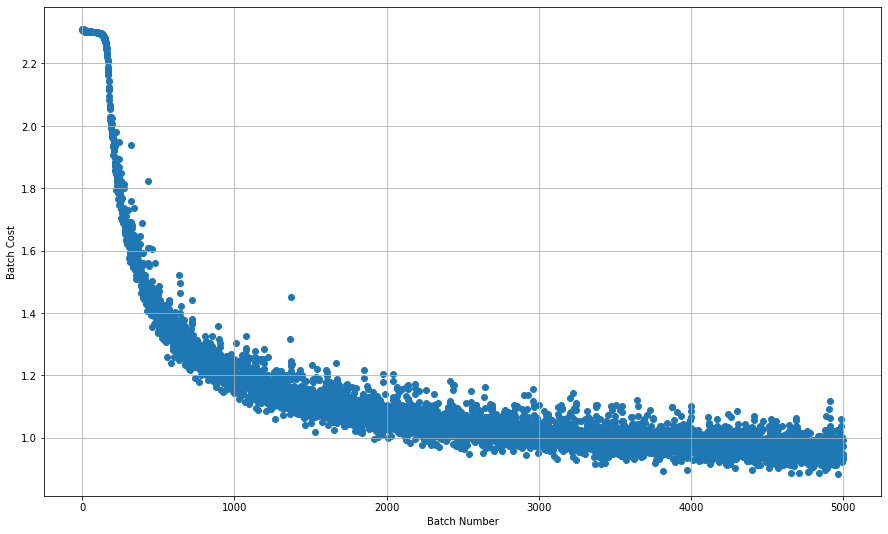

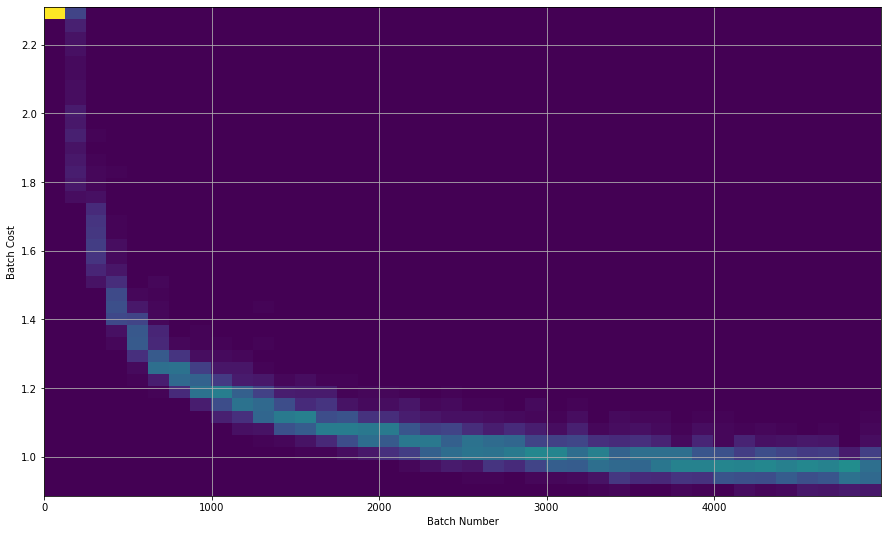

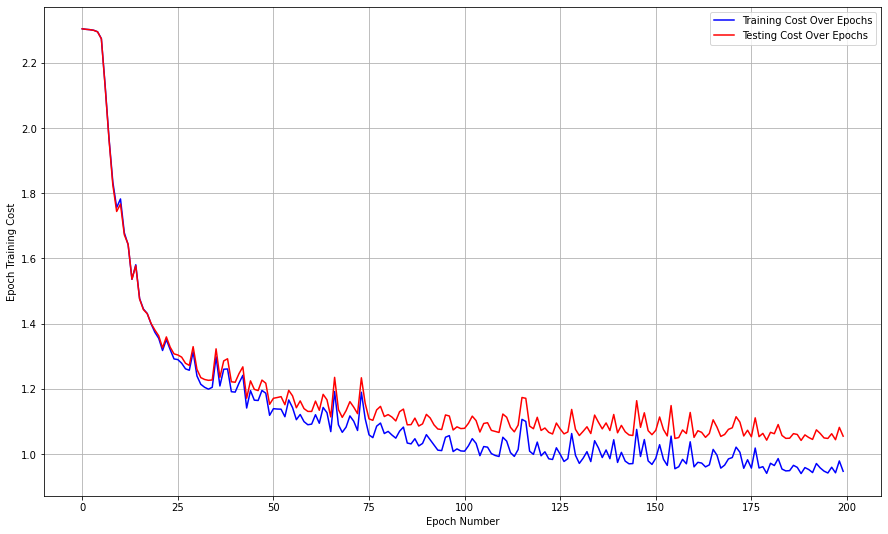

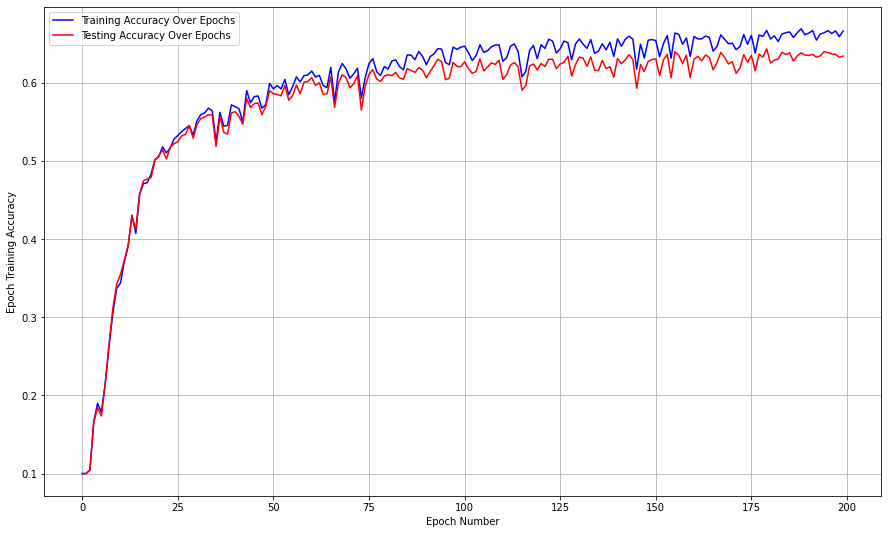

In [0]:
Results_TinerCNN1 = trainAndTestConvolutionNetworkProvided( 
    TinierCNN,
    name="Tinier Convolutional Neural Network trained at batch size 2000 lr0.05 mom0.75 epochs200.",
    silent=False,
    maxNumberOfEpochs=200,
    batch_size=2000,
    learning_rate=0.05,
    momentum=0.75
    )
print("Overall Accuracy: "+str(Results_TinerCNN1["overall_accuracy"]))
print("Extraction Time: "+str(Results_TinerCNN1["extraction_time"]))
print("Epoch Times: " +str(Results_TinerCNN1["epoch_times"]))

graphStatistics(Results_TinerCNN1)

# SECTION 2 - MULTILAYER PERCEPTRON CLASSIFIER

## MLP model from scratch

Define our MLP model

In [0]:
import numpy as np

class MLP:

    def __init__(self, num_hidden_layers=2):
        self.n_hidden_layers = num_hidden_layers
        self.weights = list()
        self.loss_through_time = [None]
        self.score_through_time = [None]

    def initialize_weights(self):
        for i in range(self.n_hidden_layers):
            # all weights have the same size = DxD (except the last weight matrix)
            # and weights have values sampled using Xavier's method
            if i == self.n_hidden_layers - 1:
                w_final = (np.random.randn(self.X.shape[1], self.Y.shape[1])) * np.sqrt(2/self.X.shape[1] + self.Y.shape[1])  # DxK
                self.weights.append(w_final)
            else:
                w = (np.random.randn(self.X.shape[1], self.X.shape[1]))* np.sqrt(2/self.X.shape[1] + self.X.shape[1])  # DxD
                self.weights.append(w)

    def train(self, x, y):
        self.X = x # N x D
        self.Y = y # N x K

        self.initialize_weights()

        # step 1: forward pass for evaluation -------------------
        layer_inputs, layer_activations = self.feedforward(self.X)
        forward_prediction = layer_activations[-1]

        # step 2: find error for the forward prediction ---------
        error = self.x_entropy_cost(forward_prediction, self.Y)
        print("error after first forward evaluation")
        print(error)
        # Step 3: do gradient descent ------------------
        # TODO hyperparams
        eps = 1e-9
        max_iters = 100
        lr = .1
        t = 0

        self.loss_through_time = [None] * max_iters
        self.score_through_time = [None] * max_iters
        print("\ngradient descent starts ------")
        while t < max_iters:
            pd_weights, loss, score = self.backpropagation()
            self.loss_through_time[t] = loss
            self.score_through_time[t] = score
            for i in range(self.n_hidden_layers):
                self.weights[i] = self.weights[i] - lr*pd_weights[i]
            t = t + 1
        # final weights are optimal, we are done training

    def predict(self, x):

        inputs, activations = self.feedforward(x)
        yh = activations[-1]

        return yh

    def backpropagation(self):
        # feedforward
        inputs, layer_activations = self.feedforward(self.X)
        yh = layer_activations[-1]
        error = self.x_entropy_cost(yh, self.Y)
        score = np.mean(np.sum(yh * self.Y, 1))

        n_layers = self.n_hidden_layers + 1
        # partial derivative of weight matrices list
        pd_weights = [None] * self.n_hidden_layers

        # gradient for the last layer
        dY = yh - self.Y
        delta_output_error = dY * self.derivative_relu(dY)

        Z = layer_activations[-2]  # the input used to multiply with the weight of the last layer
        N = self.X.shape[0]

        dw_last = np.dot(Z.T, delta_output_error)
        pd_weights[-1] = dw_last

        # error from above = delta
        delta_above = np.dot(delta_output_error, self.weights[-1].T)  # NxM

        # gradients from second-to-last-layer to second layer
        for layer_id in np.arange(n_layers - 2, 0, -1):
            # error below
            current_input = layer_activations[layer_id - 1]
            current_weight = self.weights[layer_id-1]
            input_above = layer_activations[layer_id]

            # error above
            dz = delta_above * self.derivative_relu(input_above)

            # gradient for this layer
            dW = np.dot(current_input.T, dz)
            delta_above = dz
            delta_above = np.dot(delta_above, current_weight)
            pd_weights[layer_id - 1] = dW

        return pd_weights, error, score

    def feedforward(self, x):
        # transform inputs to inputs for the next layer

        inputs = list()
        layer_activations = list()

        inputs.append(x)  # inputs[0] = original input data
        layer_activations.append(x)  # at layer 0, we have no activated

        current_input = x
        for j in range(self.n_hidden_layers):
            # X -> W*X
            intermediate_input = np.dot(current_input, self.weights[j])
            inputs.append(intermediate_input)

            if j == self.n_hidden_layers - 1:
                yh = self.softmax(intermediate_input)
                layer_activations.append(yh)

            else:
                # output of hidden layer = relu(VX)
                z = self.relu(intermediate_input)  # activated_inputs[j+1] = relu(VX)
                layer_activations.append(z)
                current_input = z
        return inputs, layer_activations

    def relu(self, x):
        return x * (x > 0)

    def derivative_relu(self, x):
        return 1 * (x > 0)

    def logsumexp(self, Z):
        # Z -> NxC
        Zmax = np.max(Z, axis=1)[:, None]
        return Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=1))[:, None]  # Shape = N

    def softmax(self, u):
        # probabiliies of yh predictions for each class
        # u -> NxC
        u_exp = np.exp(u - np.max(u, 1)[:, None])

        return u_exp / np.sum(u_exp, axis=1)[:, None]

    def x_entropy_cost(self, yh, Y):
        # U is the activated inputs in the last layer
        # relu(WX)
        return -np.mean(np.sum(yh * Y, 1) - self.logsumexp(yh))

mlp = MLP()

Debug The MLP

x_train =  (50000, 3072)
y_train =  (50000, 10)


error after first forward evaluation
2.461150171734475

gradient descent starts ------


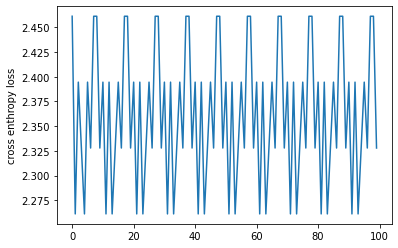

In [0]:
from keras.datasets import cifar10
from tensorflow import keras

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.reshape(-1, 3072)
x_test = x_test.reshape(-1, 3072)

num_classes = 10

# one hot-ecoded y multi-class
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print("x_train = ", x_train.shape)
print("y_train = ", y_train.shape)
print("\n")

mlp.train(x_train[:15, :], y_train[:15, :]) #reduced to 10 instances for now because I had ram issues when using the entire set

import matplotlib.pyplot as plt
plt.plot(mlp.loss_through_time)
plt.ylabel('cross enthropy loss')
plt.show()

## Train MLP with Keras

In [0]:
import time
import matplotlib.pyplot as plt
import numpy as np
import keras
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import backend as K

from keras.datasets import cifar10
from keras import optimizers
from keras import callbacks
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


In [0]:
from keras import regularizers
import math

epochs = 200
batch_size = 2000
num_classes = 10
momentum = 0.5

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.reshape(50000, 32 * 32 * 3)
X_test = X_test.reshape(10000, 32 * 32 * 3)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

print(X_train.shape)
print(X_test.shape)

# one hot-ecoded y multi-class
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# break training set into training and validation sets
#(X_train, X_valid) = X_train[5000:], X_train[:5000]
#(y_train, y_valid) = y_train[5000:], y_train[:5000]

# print shape of training set
print('X_train shape:', X_train.shape)

# print number of training, validation, and test images
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
#print(X_valid.shape[0], 'validation samples')

(50000, 3072)
(10000, 3072)
X_train shape: (50000, 3072)
50000 train samples
10000 test samples


In [0]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((45000, 32, 32, 3), (10000, 32, 32, 3), (45000, 10), (10000, 10))

In [0]:
print("starting MLP")

# MLP
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

# define the model
#model = Sequential()
#model.add(Flatten(input_shape = X_train.shape[1:]))
#model.add(Dense(1000, activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(num_classes, activation='softmax'))

model = Sequential()

model.add(Dense(1024, input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Activation('softmax'))

#Callbacks
# define step decay function
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))
        print('lr:', step_decay(len(self.losses)))

def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((epoch)/epochs_drop))
    return lrate


# learning schedule callback
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)
earlyStopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
callbacks_list = [loss_history, lrate, earlyStopping]

sgd = optimizers.SGD(lr=0.1, momentum=momentum, decay=0.0, nesterov=False) 

# compile the model
#model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.summary()

starting MLP
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              3146752   
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)  

Train on 50000 samples, validate on 10000 samples
Epoch 1/200
50000/50000 [==============================] - 2s 49us/step - loss: 2.1933 - accuracy: 0.2120 - val_loss: 1.9579 - val_accuracy: 0.2931
lr: 0.1
Epoch 2/200
50000/50000 [==============================] - 1s 14us/step - loss: 1.9615 - accuracy: 0.2964 - val_loss: 1.8612 - val_accuracy: 0.3504
lr: 0.1
Epoch 3/200
50000/50000 [==============================] - 1s 14us/step - loss: 1.8858 - accuracy: 0.3228 - val_loss: 1.8056 - val_accuracy: 0.3549
lr: 0.1
Epoch 4/200
50000/50000 [==============================] - 1s 14us/step - loss: 1.8285 - accuracy: 0.3461 - val_loss: 1.7545 - val_accuracy: 0.3852
lr: 0.1
Epoch 5/200
50000/50000 [==============================] - 1s 14us/step - loss: 1.7919 - accuracy: 0.3632 - val_loss: 1.7006 - val_accuracy: 0.3926
lr: 0.1
Epoch 6/200
50000/50000 [==============================] - 1s 14us/step - loss: 1.7471 - accuracy: 0.3812 - val_loss: 1.6915 - val_accuracy: 0.3923
lr: 0.1
Epoch 7/200
50

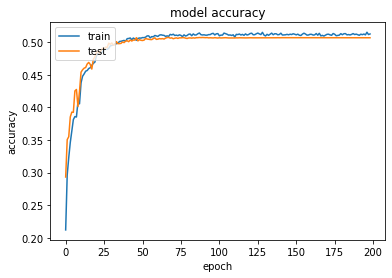

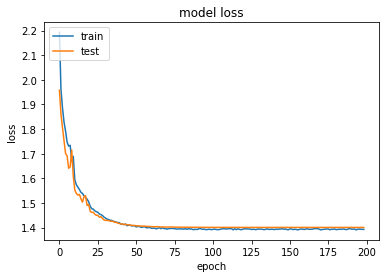

In [0]:
# training
history = model.fit(X_train, y_train,
                    callbacks=[loss_history, lrate, earlyStopping],
                    epochs=epochs, 
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(X_test, y_test))
                    #validation_data=(X_valid, y_valid))

loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test acc:', acc)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# load the weights that yielded the best validation accuracy
model.load_weights('MLP.best_weights.hdf5')
# evaluate and print test accuracy
mlp_score = model.evaluate(X_test, y_test, verbose=0)
print('\n', 'Test accuracy:', mlp_score[1])


 Test accuracy: 0.39320001006126404


Loading the data but not exactly in the same way as the tutorial followed for the CNN model

The loss is not converging